# UCB-seq vs. mcSCRB-seq Misc Figures HEK293T/17 PreAD

___

## Load Packages:

In [16]:
suppressWarnings(suppressMessages({
    library(rbin)
    library(data.table)
    library(scater)
    library(tidyverse)
    library(annotables)
    library(SummarizedExperiment)
    library(RColorBrewer)
    library(SingleCellExperiment)
    library(DescTools)
    library(gplots)
    library(eulerr)
    library(grid)
    library(gridExtra) 
    library(GenomicFeatures)
    library(GenomicRanges)
    library(BSgenome)
    }))

## Temporary Functions

In [17]:
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/uCBSeqHEK/zUMIs_output/expression')
uCBSeqHEK <- readRDS('uCBSeqHEK.dgecounts.rds')

setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/uCBSeqHEKPreAD/zUMIs_output/expression')
uCBSeqHEKPreAD <- readRDS('uCBSeqHEKPreAD.dgecounts.rds')

setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/uCBSeqPreAD/zUMIs_output/expression')
uCBSeqPreAD <- readRDS('uCBSeqPreAD.dgecounts.rds')

In [46]:
sum(uCBSeqHEKPreAD$umicount$inex$downsampling$downsampled_125000[,'TCACAGCA'])

[1] 24738

In [19]:
# colnames(tc011a$umicount$exon$downsampling$downsampled_200000)
# sum(tc011a$umicount$exon$downsampling$downsampled_200000[,'ACATGCGT']>=1)

## Preanalysis Processing

In [20]:
# Remove duplicate genes in dedup_grch38.
toRemove <- vector()
last <- 1
for (i in 2:(nrow(grch38))) {
    if (grch38[i,1] == grch38[i - 1,1]) {
        toRemove[last] <- i
        last <- last + 1
    }
}

# Create deuplicated grch38
dedup_grch38 <- grch38[-toRemove,]

# Check for duplicates in dedup_grch38
postDupCount <- 0
for (i in 1:(nrow(dedup_grch38) - 1)) {
    if (dedup_grch38[i,1] == dedup_grch38[i + 1,1]) {
        postDupCount <- postDupCount + 1
    }
}
print(paste0("There are ", postDupCount, " duplicate genes in dedup_grch38!"))

[1] "There are 0 duplicate genes in dedup_grch38!"


___

# Set Parameters for Analysis

In [21]:
# Initialize samples, barcodes, and sampleslist
experiment <- 'All Comparisons'
samples <- c('uCBSeqHEKPreAD', 'uCBSeqHEK', 'uCBSeqPreAD')
barcodesHEKPreAD <- c('TCACAGCA', 'GTAGCACT', 'ATAGCGTC', 'TGCTACAG','CGCTATGA', 'CATCGTGA', 'GGCATTGT')
barcodesHEK <- c('TCACAGCA', 'GTAGCACT', 'TGCTACAG','CGCTATGA', 'ATGCACGT', 'TATGCACG', 'CATCGTGA', 'GGCATTGT')
barcodesPreAD <- c('TCACAGCA', 'GTAGCACT', 'CGCTATGA', 'ATGCACGT', 'TATGCACG', 'CATCGTGA', 'GGCATTGT') 
HEKPreADSamplesList <- c('HEKPreAD_TCACAGCA', 'HEKPreAD_GTAGCACT', 'HEKPreAD_ATAGCGTC', 'HEKPreAD_TGCTACAG','HEKPreAD_CGCTATGA', 'HEKPreAD_CATCGTGA', 'HEKPreAD_GGCATTGT')
HEKSamplesList <- c('HEK_TCACAGCA', 'HEK_GTAGCACT', 'HEK_TGCTACAG','HEK_CGCTATGA', 'HEK_ATGCACGT', 'HEK_TATGCACG', 'HEK_CATCGTGA', 'HEK_GGCATTGT')
PreADSamplesList <- c('PreAD_TCACAGCA', 'PreAD_GTAGCACT', 'PreAD_CGCTATGA', 'PreAD_ATGCACGT', 'PreAD_TATGCACG', 'PreAD_CATCGTGA', 'PreAD_GGCATTGT') 

# Initialize Samples List
samplesList <- NULL
i <- 1
for (sample in samples) {
    if (sample == "uCBSeqHEKPreAD") {
        for (barcode in barcodesHEKPreAD) {
            eval(parse(text = paste0('samplesList[i] <- ', "'", sample, "_", barcode, "'")))
            i  <- i + 1
        }
    } else if (sample == "uCBSeqHEK") {
        for (barcode in barcodesHEK) {
            eval(parse(text = paste0('samplesList[i] <- ', "'", sample, "_", barcode, "'")))
            i  <- i + 1
        }  
    } else if (sample == "uCBSeqPreAD") {
            for (barcode in barcodesPreAD) {
            eval(parse(text = paste0('samplesList[i] <- ', "'", sample, "_", barcode, "'")))
            i  <- i + 1
        }  
    }

}

# Initialize Negatives List
fullNegList <- c()

In [22]:
# Looking at exon, intron, or intron and exon (intron.exon)
lookAt <- 'inex'

In [23]:
# Downsampling value to use for primary analysis
downsamplingSC <- '125000'

# Input Experimental Data

In [26]:
# Initialize colData
colDataNames <- c('Sample_ID', 'Cell_ID', 'NCells', 'Format', 'TotalReads', 'AlignedReads', 'AlignedFrac', 'AlignedReadsExon', 
                    'ExonFrac', 'AlignedReadsIntron', 'IntronFrac', 'AlignedReadsIntergenic', 'IntergenicFrac', 'GenesDetected', 
                    'UMIsDetected')

# Initialize Cell ID, input, etc. 
Cell_ID <- rep('HEKPreAD', length(samplesList))
NCells <- c(rep('Single Cell', length(samplesList)))
Format <- c(rep('uCB-seq', length(samplesList)))


# Initialize colData to fill in
TotalReads  <- double(length = length(samplesList))
AlignedReads <- double(length = length(samplesList))
AlignedFrac <- double(length = length(samplesList))
AlignedReadsExon <- double(length = length(samplesList))
ExonFrac <- double(length = length(samplesList))
AlignedReadsIntron <- double(length = length(samplesList))
IntronFrac <- double(length = length(samplesList))
AlignedReadsIntergenic <- double(length = length(samplesList))
IntergenicFrac <- double(length = length(samplesList))
AlignedReadsAmbiguous <- double(length = length(samplesList))
AmbiguousFrac <- double(length = length(samplesList))
GenesDetected <- double(length = length(samplesList))
UMIsDetected  <- double(length = length(samplesList))

# Initialize metaData
metaDataNames <- c('Experiment', 'Sample_ID')
Experiment <- c(rep('uCBSeqHEKPreAD', length(barcodesHEKPreAD)), rep('uCBSeqHEK', length(barcodesHEK)), rep('uCBSeqPreAD', length(barcodesPreAD)))
Sample_ID <- samplesList

___

## Build Expression Matrix from Sequencing Dataset

### Creating Individual Expression Matrices for All Samples as "______Counts"

In [27]:
# Create all individual expression matrices

i = 0
for (sample in samples) {
    if (sample == "uCBSeqHEKPreAD") {
        setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/uCBSeqHEKPreAD/zUMIs_output/expression"))
        matrixName <- paste0(sample, '_', 'Counts')
        fileName <- paste0(sample, '.dgecounts.rds')
        eval(parse(text = paste0(matrixName, " <- readRDS(","'", fileName, "'", ")")))
        for (barcode in barcodesHEKPreAD) {
            umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
            umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
            eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

            readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
            readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
            eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
        }
    } else if (sample == "uCBSeqHEK") {
        setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/uCBSeqHEK/zUMIs_output/expression"))
        matrixName <- paste0(sample, '_', 'Counts')
        fileName <- paste0(sample, '.dgecounts.rds')
        eval(parse(text = paste0(matrixName, " <- readRDS(","'", fileName, "'", ")")))
        for (barcode in barcodesHEK) {
            if (barcode == "CGCTATGA") {
                umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
                umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$all[,", "'", barcode, "']")
                eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

                readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
                readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$all[,", "'", barcode, "']")
                eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
            } else {
                umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
                umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
                eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

                readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
                readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
                eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
            }
        }
    } else if (sample == "uCBSeqPreAD") {
        setwd(paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/uCBSeqPreAD/zUMIs_output/expression"))
        matrixName <- paste0(sample, '_', 'Counts')
        fileName <- paste0(sample, '.dgecounts.rds')
        eval(parse(text = paste0(matrixName, " <- readRDS(","'", fileName, "'", ")")))
        for (barcode in barcodesPreAD) {
            if (barcode == "ATGCACGT") {
                umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
                umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$all[,", "'", barcode, "']")
                eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

                readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
                readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$all[,", "'", barcode, "']")
                eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
            } else {
                umiCountsName <- paste0(sample, '_', barcode, '_', 'UMICounts')
                umiFieldsName <- paste0(matrixName, "$umicount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
                eval(parse(text = paste0(umiCountsName, " <- as.matrix(", umiFieldsName, ")")))

                readCountsName <- paste0(sample, '_', barcode, '_', 'ReadCounts')
                readFieldsName <- paste0(matrixName, "$readcount$", lookAt, "$downsampling$downsampled_", downsamplingSC, "[,", "'", barcode, "']")
                eval(parse(text = paste0(readCountsName, " <- as.matrix(", readFieldsName, ")")))
            }
        }
    }
}

### Building Master UMI Expression Matrix and Master Readcount Expression Matrix

In [28]:
# Initialize namesList with first sample
eval(parse(text = paste0("namesList <- names(", samplesList[1], "_UMICounts[,1])")))

# Iteratively add genes present in samples but missing from namesList until namesList is fully populated
for (sample in samples) {
    if (sample == "uCBSeqHEKPreAD") {
        for (barcode in barcodesHEKPreAD) {
            if (sample == samples[1] & barcode == barcodesHEKPreAD[1]) {
            } else {
                eval(parse(text = paste0("namesList <- c(namesList, names(", sample, "_", barcode, 
                                         "_UMICounts[,1])[!names(", sample, "_", barcode, 
                                         "_UMICounts[,1]) %in% namesList])")))
            }
        }
    } else if (sample == "uCBSeqHEK") {
        for (barcode in barcodesHEK) {
            if (sample == samples[1] & barcode == barcodesHEK[1]) {
            } else {
                eval(parse(text = paste0("namesList <- c(namesList, names(", sample, "_", barcode, 
                                         "_UMICounts[,1])[!names(", sample, "_", barcode, 
                                         "_UMICounts[,1]) %in% namesList])")))
            }
        }
    } else if (sample == "uCBSeqPreAD") {
        for (barcode in barcodesPreAD) {
            if (sample == samples[1] & barcode == barcodesPreAD[1]) {
            } else {
                eval(parse(text = paste0("namesList <- c(namesList, names(", sample, "_", barcode, 
                                         "_UMICounts[,1])[!names(", sample, "_", barcode, 
                                         "_UMICounts[,1]) %in% namesList])")))
            }
        }
    }
}

# Do the same for bulk HEK sample
setwd("C:/Users/tyler/Desktop/Downsampled zUMIs/out/HEK_Bulk/")
temp <- as.matrix(read.csv('HEK_Bulk.csv'))
bulkMatrix <- as.numeric(as.matrix(temp[,3]))
# Establish ENSG ID as rownames
names(bulkMatrix) <- temp[,1]
# Add bulk genes to namesList
namesList <- c(namesList, names(bulkMatrix)[!names(bulkMatrix) %in% namesList])

# Sort namesList
namesList <- sort(namesList)

# Create matrix with all zeros containing all names for comparison against all samples
namesMatrix <- as.vector(numeric(length(namesList)), "list")
names(namesMatrix) = namesList

In [29]:
#Define function fillSparseMatrix to fill out and order each sample's matrix

fillSparseMatrix <- function(inputMatrix, namesList) {
    missingNames <- names(namesMatrix)[!names(namesMatrix) %in% names(inputMatrix[,1])]
    missingNames
    missingMatrix <- as.vector(numeric(length(missingNames)), "list")
    names(missingMatrix) <- missingNames
    fullInputMatrix <- do.call(cbind, c(inputMatrix[,1], missingMatrix))
    fullInputMatrix <- fullInputMatrix[, order(names(fullInputMatrix[1,]))]
    return(fullInputMatrix)
}

In [30]:
# Run fillSparseMatrix on all UMI samples
for (sampleName in samplesList) {
    eval(parse(text = paste0(sampleName, " <- fillSparseMatrix(", sampleName, "_UMICounts)")))
}

# Run fillSparseMatrix on Bulk
    missingNames <- names(namesMatrix)[!names(namesMatrix) %in% names(bulkMatrix)]
    missingMatrix <- as.vector(numeric(length(missingNames)), "list")
    names(missingMatrix) <- missingNames
    fullInputMatrix <- do.call(cbind, c(bulkMatrix, missingMatrix))
    Bulk <- fullInputMatrix[, order(names(fullInputMatrix[1,]))]

# Bind all filled matrices into final umiMatrix
eval(parse(text = paste0("temp <- rbind(", samplesList[1], ", ", samplesList[2], ")")))

for (i in 3:length(samplesList)) {
    if (i == length(samplesList)) {
        eval(parse(text = paste0("umiMatrix <- rbind(temp, ", samplesList[i], ")")))
    } else {
        eval(parse(text = paste0("temp <- rbind(temp, ", samplesList[i], ")")))
    }
}

umiMatrix <- t(umiMatrix)

In [31]:
# Run fillSparseMatrix on all readcount samples
for (sampleName in samplesList) {
    eval(parse(text = paste0(sampleName, " <- fillSparseMatrix(", sampleName, "_ReadCounts)")))
}

# Bind all filled matrices into final umiMatrix
eval(parse(text = paste0("temp <- rbind(", samplesList[1], ", ", samplesList[2], ")")))

for (i in 3:length(samplesList)) {
    if (i == length(samplesList)) {
        eval(parse(text = paste0("readMatrix <- rbind(temp, ", samplesList[i], ")")))
    } else {
        eval(parse(text = paste0("temp <- rbind(temp, ", samplesList[i], ")")))
    }
}

readMatrix <- t(readMatrix)

_____

# Pull GC and Length Genomic Information

In [32]:
# Pull txdb info from Ensembl directly
# txdb <- makeTxDbFromEnsembl(organism="Homo sapiens",
#                     release=NA,
#                     circ_seqs=DEFAULT_CIRC_SEQS,
#                     server="ensembldb.ensembl.org")

In [33]:
# Pull txdb info from saved sqlite of Ensembl database
setwd('C:/Users/tyler/OneDrive/Streets Lab/Jupyter/')
txdb <- loadDb("ensemblTxdb.sqlite")

In [34]:
# Get transcripts by Gene, tidy for only Chr1-22, X, Y, MT 
tx_by_gene <- transcriptsBy(txdb, 'gene')
rm(txdb)
genome <- getBSgenome("GRCh38")
seqlevels(tx_by_gene, pruning.mode = "tidy") <- c('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y', 'MT')
genome(tx_by_gene) <- "GRCh38"

In [35]:
# Extract the transcript sequences grouped by gene:
txseq_by_gene <- getSeq(genome, tx_by_gene)
rm(tx_by_gene)
# Compute the transcript GC, AT, and total nucleotide counts grouped by gene:
af <- alphabetFrequency(unlist(txseq_by_gene, use.names=FALSE), baseOnly=TRUE)
txGCcount_by_gene <- relist(af[ , "C"] + af[ , "G"], txseq_by_gene)
txlength_by_gene <- relist(af[ , "C"] + af[ , "G"] + af[,"A"] + af[,"T"], txseq_by_gene)
txATcount_by_gene <- relist(af[,"A"] + af[,"T"], txseq_by_gene)
rm(af)

In [36]:
# Create dataframe with %GC and length by Ensembl ID
geneData <- as.data.frame(txGCcount_by_gene)
colnames(geneData)[colnames(geneData)=="value"] <- "GC_count"
colnames(geneData)[colnames(geneData)=="group_name"] <- "Ensembl ID"
geneData$Length = as.data.frame(txlength_by_gene)[,'value']
geneData$GC = geneData$GC_count / geneData$Length
geneData <- geneData[,-which(names(geneData) %in% c('group', 'GC_count'))]
geneData <- split(geneData, geneData$'Ensembl ID')

____

## Convert Matrices to Tibbles for Visualization

In [37]:
# Create umiTibble and readTibble

# Number of genedata variables (e.g. Ensembl ID, Gene Symbol, etc.)
numGeneData <- 12

# Create and fill umiTibble and readTibble
umiTibble <- tibble('Ensembl ID' = names(umiMatrix[,1]))
readTibble <- tibble('Ensembl ID' = names(readMatrix[,1]))
for (ID in names(umiMatrix[,1])) {
    ti <- umiTibble[,1] == ID
    gi <- dedup_grch38[,1] == ID
    
    # Input basic GRCh38 Gene Data
    if (sum(gi) != 0) {
        umiTibble[ti, 'Gene Symbol'] <- dedup_grch38[gi, "symbol"]
        umiTibble[ti, 'Biotype'] <- dedup_grch38[gi, "biotype"]
        umiTibble[ti, 'Description'] <- dedup_grch38[gi, "description"]
        readTibble[ti, 'Gene Symbol'] <- dedup_grch38[gi, "symbol"]
        readTibble[ti, 'Biotype'] <- dedup_grch38[gi, "biotype"]
        readTibble[ti, 'Description'] <- dedup_grch38[gi, "description"]
    } else {
        umiTibble[ti, 'Gene Symbol'] <- NA
        umiTibble[ti, 'Biotype'] <- NA
        umiTibble[ti, 'Description'] <- NA
        readTibble[ti, 'Gene Symbol'] <- NA
        readTibble[ti, 'Biotype'] <- NA
        readTibble[ti, 'Description'] <- NA
    }
    
    # Input gene and transcript-level data
    if (eval(parse(text = paste0('is.null(geneData$', ID, ')')))) {
        umiTibble[ti, 'MaxLen'] <- NA
        umiTibble[ti, 'MinLen'] <- NA
        umiTibble[ti, 'MeanLen'] <- NA
        umiTibble[ti, 'MedianLen'] <- NA
        umiTibble[ti, 'MaxGC'] <- NA
        umiTibble[ti, 'MinGC'] <- NA
        umiTibble[ti, 'MeanGC'] <- NA
        umiTibble[ti, 'MedianGC'] <- NA
        
        readTibble[ti, 'MaxLen'] <- NA
        readTibble[ti, 'MinLen'] <- NA
        readTibble[ti, 'MeanLen'] <- NA
        readTibble[ti, 'MedianLen'] <- NA
        readTibble[ti, 'MaxGC'] <- NA
        readTibble[ti, 'MinGC'] <- NA
        readTibble[ti, 'MeanGC'] <- NA
        readTibble[ti, 'MedianGC'] <- NA
    } else {
        umiTibble[ti, 'MaxLen'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MinLen'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MeanLen'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MedianLen'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"Length"])')))
        umiTibble[ti, 'MaxGC'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"GC"])')))
        umiTibble[ti, 'MinGC'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"GC"])')))
        umiTibble[ti, 'MeanGC'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"GC"])')))
        umiTibble[ti, 'MedianGC'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"GC"])')))
        
        readTibble[ti, 'MaxLen'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MinLen'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MeanLen'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MedianLen'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"Length"])')))
        readTibble[ti, 'MaxGC'] <- eval(parse(text = paste0('max(geneData$', ID, '[,"GC"])')))
        readTibble[ti, 'MinGC'] <- eval(parse(text = paste0('min(geneData$', ID, '[,"GC"])')))
        readTibble[ti, 'MeanGC'] <- eval(parse(text = paste0('mean(geneData$', ID, '[,"GC"])')))
        readTibble[ti, 'MedianGC'] <- eval(parse(text = paste0('median(geneData$', ID, '[,"GC"])')))
    }
}

# Add samples into Tibble
for (i in 1:length(samplesList)) {
    eval(parse(text = paste0('umiTibble$', samplesList[i], " = umiMatrix[,i]")))
    eval(parse(text = paste0('readTibble$', samplesList[i], " = readMatrix[,i]")))    
}

In [38]:
# REMOVES NEGATIVE CONTROLS FROM TIBBLE!!!
# umiTibble <- dplyr::select(umiTibble, -fullNegList)
# readTibble <- dplyr::select(readTibble, -fullNegList)

In [39]:
# Add Summary Data (including bulk data) into Tibble
numSummaryData <- 1

# # uCB-seq total Read/UMI count Total RNA
# umiTibble$ucbtrUMICount = rowSums(dplyr::select(umiTibble, contains('TC012')))
# readTibble$ucbtrReadCount = rowSums(dplyr::select(readTibble, contains('TC012')))
# # uCB-seq total Read/UMI count Single Cell
# umiTibble$ucbscUMICount = rowSums(dplyr::select(umiTibble, contains('TC014')))
# readTibble$ucbscReadCount = rowSums(dplyr::select(readTibble, contains('TC014')))
# # mcSCRB-seq total Read/UMI count Total RNA
# umiTibble$mctrUMICount = rowSums(dplyr::select(umiTibble, contains('TC010')))
# readTibble$mctrReadCount = rowSums(dplyr::select(readTibble, contains('TC010')))
# # mcSCRB-seq total Read/UMI count Single Cell
# umiTibble$mcscUMICount = rowSums(dplyr::select(umiTibble, contains('TC011')))
# readTibble$mcscReadCount = rowSums(dplyr::select(readTibble, contains('TC011')))

# # Add detection percentage for Total RNA and Single Cell uCB and mcSCRB
# # uCB-seq  Total RNA
# umiTibble$ucbtrDetection = rowSums(dplyr::select(umiTibble, contains('TC012')) > 0) / ncol(dplyr::select(umiTibble, contains('TC012')))
# readTibble$ucbtrDetection = rowSums(dplyr::select(readTibble, contains('TC012')) > 0) / ncol(dplyr::select(readTibble, contains('TC012')))
# # uCB-seq Detection Percent Single Cell
# umiTibble$ucbscDetection = rowSums(dplyr::select(umiTibble, contains('TC014')) > 0) / ncol(dplyr::select(umiTibble, contains('TC014')))
# readTibble$ucbscDetection = rowSums(dplyr::select(readTibble, contains('TC014')) > 0) / ncol(dplyr::select(readTibble, contains('TC014')))
# # mcSCRB-seq Detection Percent Total RNA
# umiTibble$mctrDetection = rowSums(dplyr::select(umiTibble, contains('TC010')) > 0) / ncol(dplyr::select(umiTibble, contains('TC010')))
# readTibble$mctrDetection = rowSums(dplyr::select(readTibble, contains('TC010')) > 0) / ncol(dplyr::select(readTibble, contains('TC010')))
# # mcSCRB-seq Detection Percent Single Cell
# umiTibble$mcscDetection = rowSums(dplyr::select(umiTibble, contains('TC011')) > 0) / ncol(dplyr::select(umiTibble, contains('TC011')))
# readTibble$mcscDetection = rowSums(dplyr::select(readTibble, contains('TC011')) > 0) / ncol(dplyr::select(readTibble, contains('TC011')))

# # Add pairwise detection prob for Total RNA and Single Cell uCB and mcSCRB
# # uCB-seq  Pairwise Total RNA
# umiTibble$ucbtrPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC012')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC012'))), 2)
# readTibble$ucbtrPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC012')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC012'))), 2)
# # uCB-seq Pairwise Detection Percent Single Cell
# umiTibble$ucbscPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC014')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC014'))), 2)
# readTibble$ucbscPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC014')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC014'))), 2)
# # mcSCRB-seq Pairwise Detection Percent Total RNA
# umiTibble$mctrPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC010')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC010'))), 2)
# readTibble$mctrPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC010')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC010'))), 2)
# # mcSCRB-seq Pairwise Detection Percent Single Cell
# umiTibble$mcscPairDetection = choose(rowSums(dplyr::select(umiTibble, contains('TC011')) > 0), 2) / choose(ncol(dplyr::select(umiTibble, contains('TC011'))), 2)
# readTibble$mcscPairDetection = choose(rowSums(dplyr::select(readTibble, contains('TC011')) > 0), 2) / choose(ncol(dplyr::select(readTibble, contains('TC011'))), 2)

# # Total Counts
# umiTibble$TotalUMICount = rowSums(dplyr::select(umiTibble, contains('TC0')))
# readTibble$TotalReadCount = rowSums(dplyr::select(readTibble, contains('TC0')))

# Add Bulk HEK Counts into Tibble
umiTibble$Bulk = Bulk

In [41]:
# View umiTibble by total counts
umiTibble
readTibble %>% arrange(desc(TotalReadCount))

Ensembl ID,Gene Symbol,Biotype,Description,MaxLen,MinLen,MeanLen,MedianLen,MaxGC,MinGC,...,uCBSeqHEK_CATCGTGA,uCBSeqHEK_GGCATTGT,uCBSeqPreAD_TCACAGCA,uCBSeqPreAD_GTAGCACT,uCBSeqPreAD_CGCTATGA,uCBSeqPreAD_ATGCACGT,uCBSeqPreAD_TATGCACG,uCBSeqPreAD_CATCGTGA,uCBSeqPreAD_GGCATTGT,Bulk
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,protein_coding,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],9996,4149,6774.80,6550.0,0.4393098,0.4043617,...,2,1,0,1,0,0,0,0,0,4979.54500
ENSG00000000005,TNMD,protein_coding,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],15084,3908,9496.00,9496.0,0.4080483,0.3955988,...,0,0,0,0,0,0,0,0,0,8.00000
ENSG00000000419,DPM1,protein_coding,"dolichyl-phosphate mannosyltransferase subunit 1, catalytic [Source:HGNC Symbol;Acc:HGNC:3005]",23689,10966,21330.83,23630.5,0.4027697,0.3984969,...,0,0,2,1,3,3,0,0,1,1872.00300
ENSG00000000457,SCYL3,protein_coding,SCY1 like pseudokinase 3 [Source:HGNC Symbol;Acc:HGNC:19285],44322,34834,39122.80,39757.0,0.4091979,0.3994137,...,0,0,0,0,0,0,0,0,0,684.44470
ENSG00000000460,C1orf112,protein_coding,chromosome 1 open reading frame 112 [Source:HGNC Symbol;Acc:HGNC:25565],191079,9305,53700.00,57117.0,0.3923770,0.3692246,...,0,0,0,1,0,0,0,0,0,1991.82200
ENSG00000000971,CFH,protein_coding,complement factor H [Source:HGNC Symbol;Acc:HGNC:4883],95627,4179,48451.17,49516.0,0.3881311,0.3462905,...,0,0,0,0,0,0,0,0,0,22.52520
ENSG00000001036,FUCA2,protein_coding,"fucosidase, alpha-L- 2, plasma [Source:HGNC Symbol;Acc:HGNC:4008]",16880,5171,10599.00,9746.0,0.4088184,0.3968602,...,1,3,0,2,0,0,1,1,2,5541.27100
ENSG00000001084,GCLC,protein_coding,glutamate-cysteine ligase catalytic subunit [Source:HGNC Symbol;Acc:HGNC:4311],94506,638,30029.80,32045.0,0.4278549,0.3963229,...,0,0,0,1,0,1,0,0,0,1805.13900
ENSG00000001167,NFYA,protein_coding,nuclear transcription factor Y subunit alpha [Source:HGNC Symbol;Acc:HGNC:7804],27032,24968,26000.00,26000.0,0.4006328,0.4000074,...,1,1,0,0,0,0,0,0,1,2857.99700


ERROR: Error: object 'TotalReadCount' not found


In [42]:
write.table(umiTibble, file = 'umiTibble_uCBSeqImaging.csv', append = FALSE, sep = ",", row.names = FALSE)

In [100]:
# Remove rRNA from Tibble
# mtRNALocationUMI <- which(umiTibble$Biotype == 'Mt_rRNA')
# umiTibble <- umiTibble[-mtRNALocationUMI,]

# mtRNALocationRead <- which(readTibble$Biotype == 'Mt_rRNA')
# readTibble <- readTibble[-mtRNALocationRead,]

In [101]:
# # Search for Genes of Interest
# umiTibble[which(umiTibble$'Gene Symbol' == 'ACTB'),]
# umiTibble[umiTibble$'Gene Symbol' == 'PGK1',]
# umiTibble[umiTibble$'Gene Symbol' == 'PPIA',]


_______

## Fill Out MetaData

In [102]:
# Pull Column Data from zUMIs Output
i <- 1
for (sample in samples) {
    if (grepl('TC010', sample)) {
        fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC010Final/", sample, ".readspercell.txt")
        totalTxt <- read.delim(fileTotalReads, header = FALSE, colClasses = 'character')

        for (barcode in barcodes) {
            AlignedReadsExon[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Exon'),2])
            AlignedReadsIntron[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intron'),2])
            AlignedReadsAmbiguous[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Ambiguity'),2])
            AlignedReadsIntergenic[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intergenic'),2])
            AlignedReads[i] <- sum(AlignedReadsExon[i], AlignedReadsIntron[i], AlignedReadsAmbiguous[i], AlignedReadsIntergenic[i])
            TotalReads[i] <- sum(AlignedReads[i], as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Unmapped'),2]))
            ExonFrac[i] <- AlignedReadsExon[i] / TotalReads[i]
            IntronFrac[i] <- AlignedReadsIntron[i] / TotalReads[i]
            AmbiguousFrac[i] <- AlignedReadsAmbiguous[i] / TotalReads[i]
            IntergenicFrac[i] <- AlignedReadsIntergenic[i] / TotalReads[i]
            AlignedFrac[i] <- AlignedReads[i] / TotalReads[i]

            eval(parse(text = paste0('GenesDetected[i] <- sum(umiTibble$', sample, '_', barcode, ' >= 1)')))
            eval(parse(text = paste0('UMIsDetected[i] <- sum(umiTibble$', sample, '_', barcode, ')')))
            i <- i + 1
        }
    } else if (grepl('TC012', sample)) {
        fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC012Final/", sample, ".readspercell.txt")
        totalTxt <- read.delim(fileTotalReads, header = FALSE, colClasses = 'character')
        for (barcode in barcodes12) {
            AlignedReadsExon[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Exon'),2])
            AlignedReadsIntron[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intron'),2])
            AlignedReadsAmbiguous[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Ambiguity'),2])
            AlignedReadsIntergenic[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intergenic'),2])
            AlignedReads[i] <- sum(AlignedReadsExon[i], AlignedReadsIntron[i], AlignedReadsAmbiguous[i], AlignedReadsIntergenic[i])
            TotalReads[i] <- sum(AlignedReads[i], as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Unmapped'),2]))
            ExonFrac[i] <- AlignedReadsExon[i] / TotalReads[i]
            IntronFrac[i] <- AlignedReadsIntron[i] / TotalReads[i]
            AmbiguousFrac[i] <- AlignedReadsAmbiguous[i] / TotalReads[i]
            IntergenicFrac[i] <- AlignedReadsIntergenic[i] / TotalReads[i]
            AlignedFrac[i] <- AlignedReads[i] / TotalReads[i]

            eval(parse(text = paste0('GenesDetected[i] <- sum(umiTibble$', sample, '_', barcode, ' >= 1)')))
            eval(parse(text = paste0('UMIsDetected[i] <- sum(umiTibble$', sample, '_', barcode, ')')))
            i <- i + 1
        }
    } else if (grepl('TC011', sample) | grepl('TC014', sample)) {
        if (grepl('TC011', sample)) {
            fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC011Final/", sample, ".readspercell.txt")
        }
        else {
            fileTotalReads <- paste0("C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC014Final/", sample, ".readspercell.txt")
        }
        totalTxt <- read.delim(fileTotalReads, header = FALSE, colClasses = 'character')
        for (barcode in barcodes) {
            AlignedReadsExon[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Exon'),2])
            AlignedReadsIntron[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intron'),2])
            AlignedReadsAmbiguous[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Ambiguity'),2])
            AlignedReadsIntergenic[i] <- as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Intergenic'),2])
            AlignedReads[i] <- sum(AlignedReadsExon[i], AlignedReadsIntron[i], AlignedReadsAmbiguous[i], AlignedReadsIntergenic[i])
            TotalReads[i] <- sum(AlignedReads[i], as.double(totalTxt[(totalTxt[,1] == barcode & totalTxt[,3] == 'Unmapped'),2]))
            ExonFrac[i] <- AlignedReadsExon[i] / TotalReads[i]
            IntronFrac[i] <- AlignedReadsIntron[i] / TotalReads[i]
            AmbiguousFrac[i] <- AlignedReadsAmbiguous[i] / TotalReads[i]
            IntergenicFrac[i] <- AlignedReadsIntergenic[i] / TotalReads[i]
            AlignedFrac[i] <- AlignedReads[i] / TotalReads[i]

            eval(parse(text = paste0('GenesDetected[i] <- sum(umiTibble$', sample, '_', barcode, ' >= 1)')))
            eval(parse(text = paste0('UMIsDetected[i] <- sum(umiTibble$', sample, '_', barcode, ')')))
            i <- i + 1
        }
    }
}

Warning message:
"Unknown or uninitialised column: 'TC011C_TCACAGCA'."Warning message:
"Unknown or uninitialised column: 'TC011C_TCACAGCA'."Warning message:
"Unknown or uninitialised column: 'TC011C_ATACGTGC'."Warning message:
"Unknown or uninitialised column: 'TC011C_ATACGTGC'."Warning message:
"Unknown or uninitialised column: 'TC011C_GCAGTATC'."Warning message:
"Unknown or uninitialised column: 'TC011C_GCAGTATC'."Warning message:
"Unknown or uninitialised column: 'TC011D_TCACAGCA'."Warning message:
"Unknown or uninitialised column: 'TC011D_TCACAGCA'."Warning message:
"Unknown or uninitialised column: 'TC014A_CTACGACA'."Warning message:
"Unknown or uninitialised column: 'TC014A_CTACGACA'."Warning message:
"Unknown or uninitialised column: 'TC014B_GCAGTATC'."Warning message:
"Unknown or uninitialised column: 'TC014B_GCAGTATC'."

In [103]:
# Bind all column data into final data frame
colToBind <- ""
for (name in colDataNames) {
    if (name == colDataNames[length(colDataNames)]) {
        colToBind <- paste0(colToBind, name)
    } else {
        colToBind <- paste0(colToBind, name, ", ")
    }
}
col <- t(eval(parse(text = paste0("rbind(", colToBind, ")"))))
col_DF <- DataFrame(col, row.names = samplesList)
col_DF

# Bind all metadata into final data frame
metaToBind <- ""
for (name in metaDataNames) {
    if (name == metaDataNames[length(metaDataNames)]) {
        metaToBind <- paste0(metaToBind, name)
    } else {
        metaToBind <- paste0(metaToBind, name, ", ")
    }
}
meta <- t(eval(parse(text = paste0("rbind(", metaToBind, ")"))))
meta_DF <- DataFrame(meta, row.names = samplesList)

DataFrame with 80 rows and 15 columns
                      Sample_ID  Cell_ID      NCells     Format TotalReads
                       <factor> <factor>    <factor>   <factor>   <factor>
TC010A_TCACAGCA TC010A_TCACAGCA  HEK293T    10pg RNA mcSCRB-seq    1512176
TC010A_GTAGCACT TC010A_GTAGCACT  HEK293T    10pg RNA mcSCRB-seq    1699981
TC010A_ATAGCGTC TC010A_ATAGCGTC  HEK293T    10pg RNA mcSCRB-seq    1419519
TC010A_CTAGCTGA TC010A_CTAGCTGA  HEK293T    10pg RNA mcSCRB-seq    1574183
TC010A_CTACGACA TC010A_CTACGACA  HEK293T    10pg RNA mcSCRB-seq    1581351
...                         ...      ...         ...        ...        ...
TC014B_GTACGCAT TC014B_GTACGCAT  HEK293T Single Cell    uCB-seq     570252
TC014B_ACATGCGT TC014B_ACATGCGT  HEK293T Single Cell    uCB-seq     445705
TC014B_GCATGTAC TC014B_GCATGTAC  HEK293T Single Cell    uCB-seq     668187
TC014B_ATACGTGC TC014B_ATACGTGC  HEK293T Single Cell    uCB-seq     843948
TC014B_GCAGTATC TC014B_GCAGTATC  HEK293T Single Cell    uCB-se

_______

## Create Summarized Experiment with MetaData and Tibble

In [104]:
# Create SummarizedExperiment
inputUMI <- as.matrix(umiTibble)
inputUMI <- inputUMI[,-c(1:numGeneData, (length(samplesList)+(numGeneData+1)):(length(samplesList)+(numSummaryData)+(numGeneData+1)))]
uCB_PoC <- SummarizedExperiment(assays = list(counts = inputUMI), colData = col_DF, metadata = meta_DF)
rownames(uCB_PoC) <- umiTibble$"Gene Symbol"
uCB_PoC

ERROR: Error in .validate_names(colnames, ans_colnames, "assay colnames()", "colData rownames()"): assay colnames() must be NULL or identical to colData rownames()


___________

## Plot QC Metrics

In [105]:
# cc <- c(brewer.pal(9, "Set1")) # Define a color scheme
colData_Tibble <- as_tibble(colData(uCB_PoC))
colData_Tibble
# Make tibble entries numeric
for (metric in names(col_DF)) {
    if (metric == "Cell_ID" || metric == "Format") {
        next
    } else {
        eval(parse(text = paste0("colData_Tibble$", metric, "=as.numeric(levels(colData_Tibble$", metric, 
                                 "))[colData_Tibble$", metric, "]")))
    }
}

Sample_ID,Cell_ID,NCells,Format,TotalReads,AlignedReads,AlignedFrac,AlignedReadsExon,ExonFrac,AlignedReadsIntron,IntronFrac,AlignedReadsIntergenic,IntergenicFrac,GenesDetected,UMIsDetected
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TC010A_TCACAGCA,HEK293T,10pg RNA,mcSCRB-seq,1512176,1306177,0.863773132227995,974424,0.644385309646496,124346,0.0822298462612818,156093,0.103224095607919,2281,6319
TC010A_GTAGCACT,HEK293T,10pg RNA,mcSCRB-seq,1699981,1465091,0.861827867487931,1082738,0.636911824308625,142025,0.0835450513858684,184342,0.108437682538805,2464,6782
TC010A_ATAGCGTC,HEK293T,10pg RNA,mcSCRB-seq,1419519,1233484,0.868945044060699,922422,0.649813070483734,120602,0.0849597645399604,140579,0.0990328414061383,2376,6610
TC010A_CTAGCTGA,HEK293T,10pg RNA,mcSCRB-seq,1574183,1388868,0.882278616907945,1030090,0.654364835600435,135065,0.0858000626356656,165689,0.10525396348455,2397,6516
TC010A_CTACGACA,HEK293T,10pg RNA,mcSCRB-seq,1581351,1379028,0.872056867830102,1034826,0.654393616597454,124211,0.0785473939688279,163327,0.10328320530989,2389,6463
TC010A_GTACGCAT,HEK293T,10pg RNA,mcSCRB-seq,1555842,1339928,0.861223697521985,980486,0.630196382409011,140704,0.0904359183001873,165427,0.106326349333673,2404,6433
TC010A_ACATGCGT,HEK293T,10pg RNA,mcSCRB-seq,1426755,1248182,0.874839758753255,924267,0.647810591166668,118478,0.0830401855959853,158892,0.111366001871379,2350,6086
TC010A_GCATGTAC,HEK293T,10pg RNA,mcSCRB-seq,1452518,1232704,0.848666935624894,909237,0.62597296556738,120713,0.0831060269132637,153727,0.105834833027887,2318,6231
TC010A_ATACGTGC,HEK293T,10pg RNA,mcSCRB-seq,1315591,1137800,0.86485845524939,822785,0.625410936985735,118979,0.0904376816198955,154589,0.117505364509183,2181,5703


Warning message in eval(parse(text = paste0("colData_Tibble$", metric, "=as.numeric(levels(colData_Tibble$", :
"NAs introduced by coercion"Warning message in eval(parse(text = paste0("colData_Tibble$", metric, "=as.numeric(levels(colData_Tibble$", :
"NAs introduced by coercion"

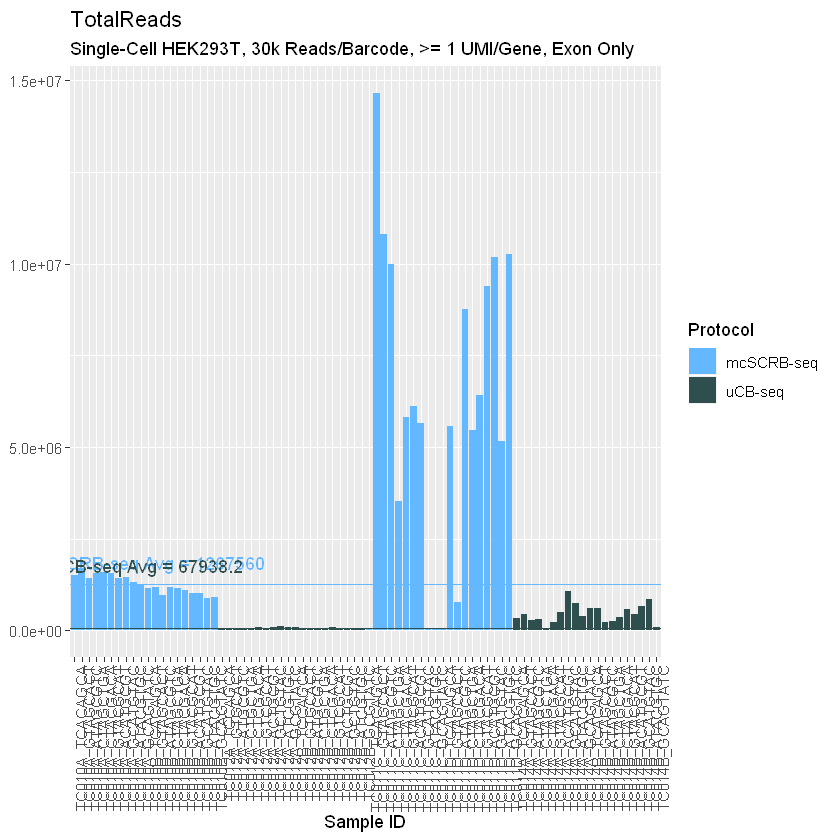

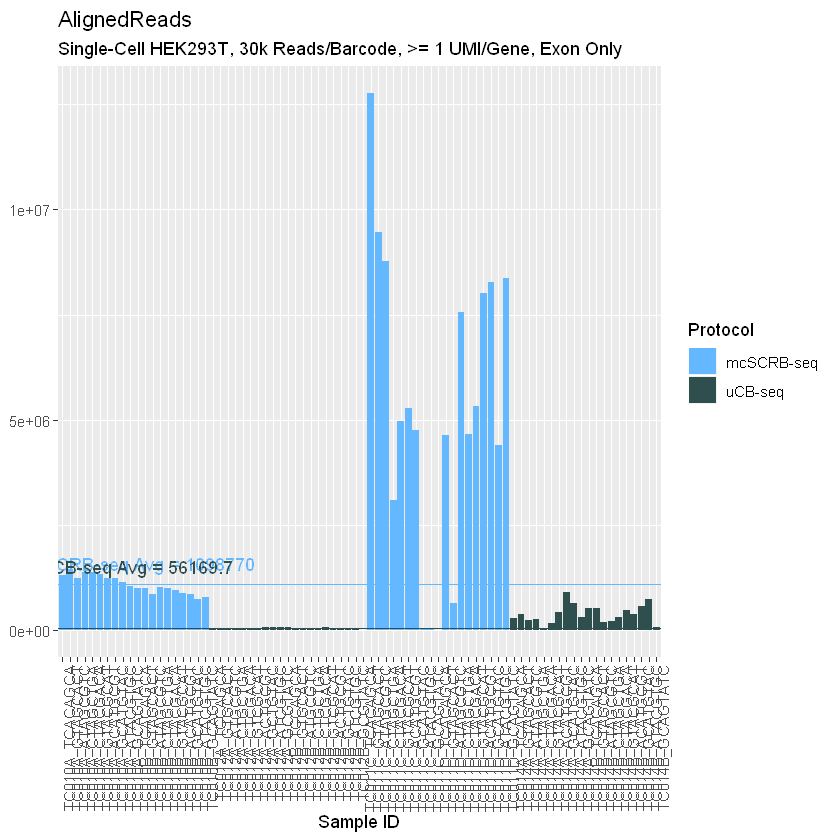

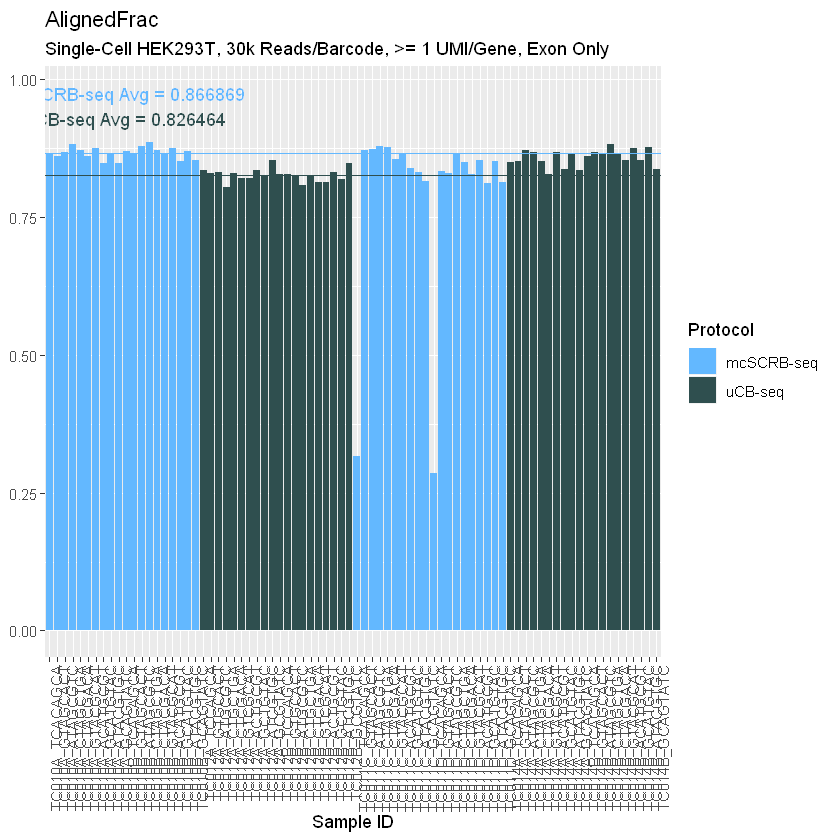

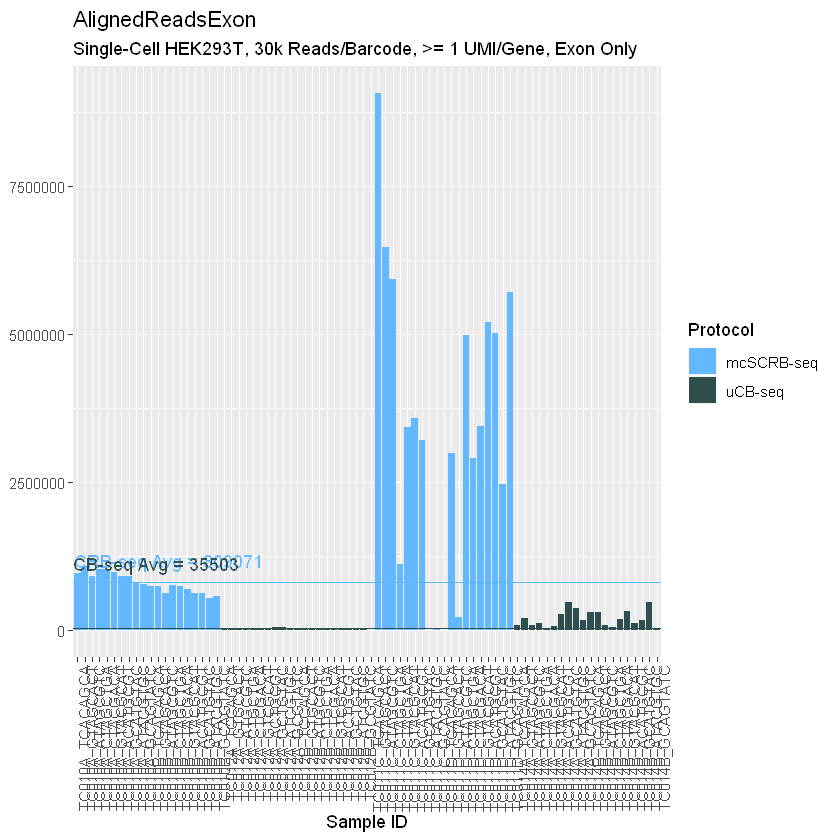

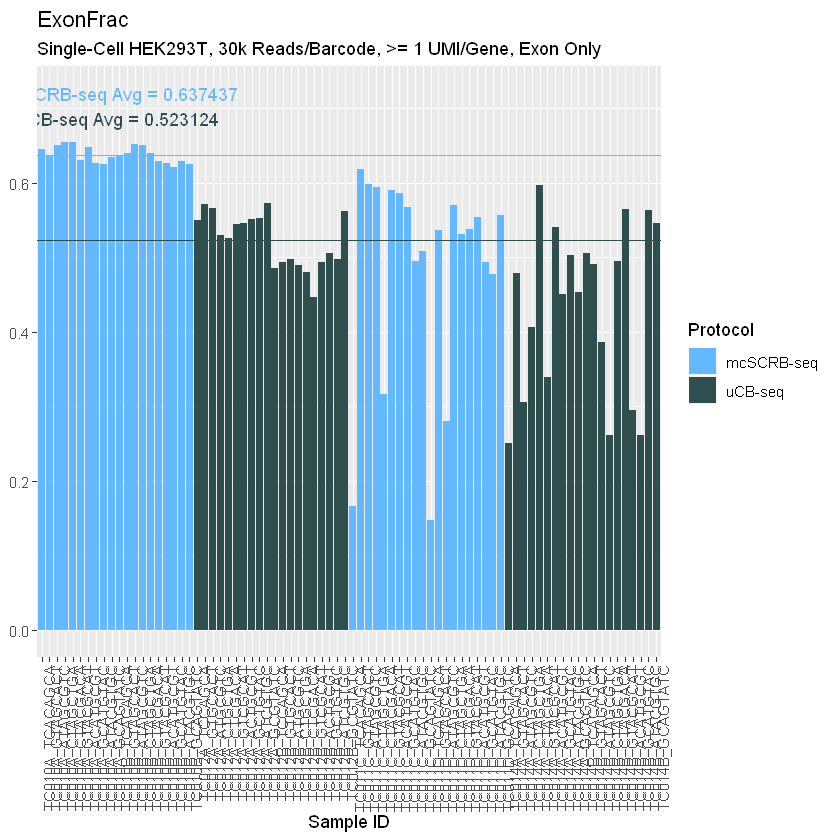

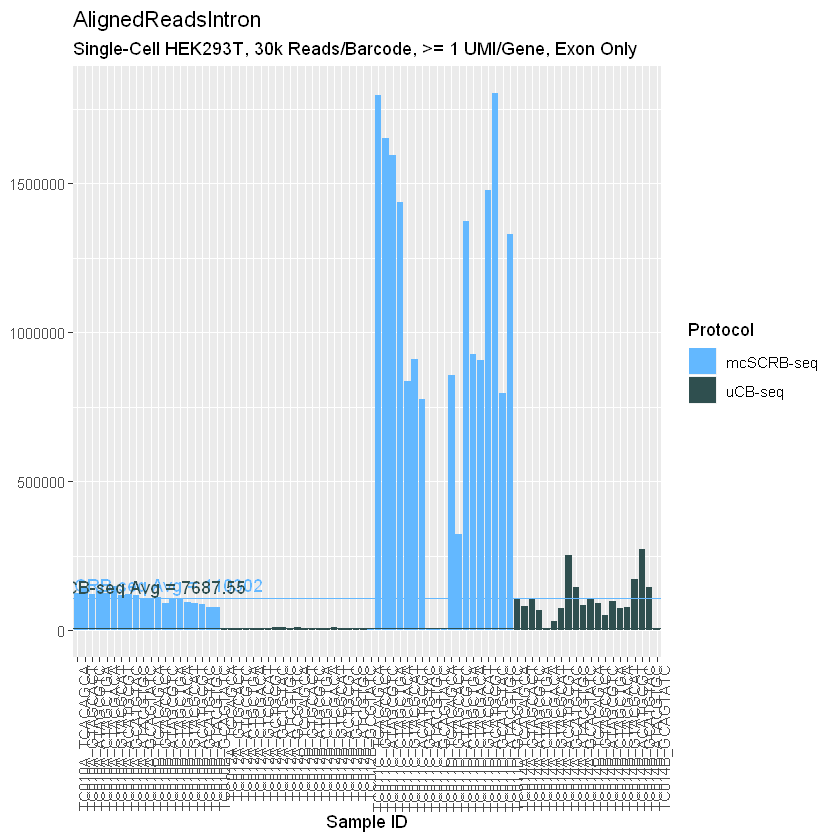

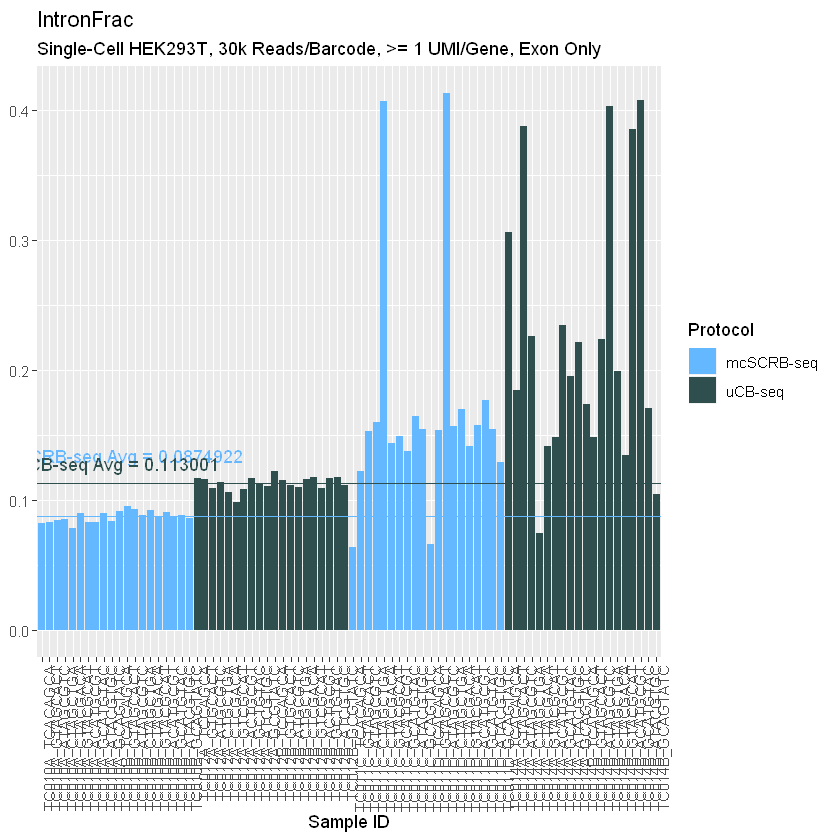

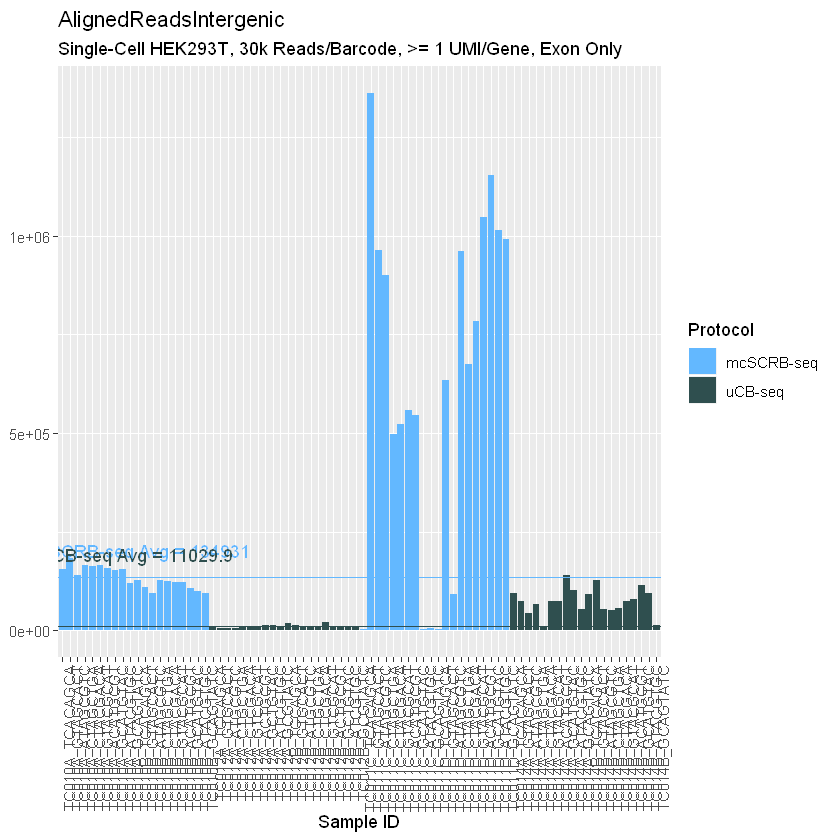

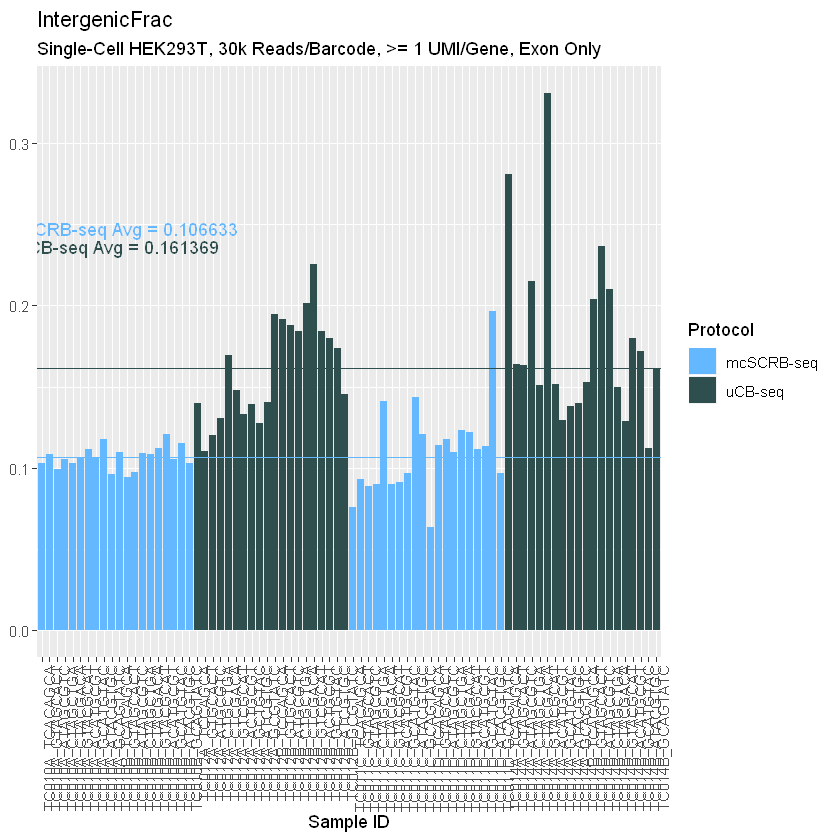

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]


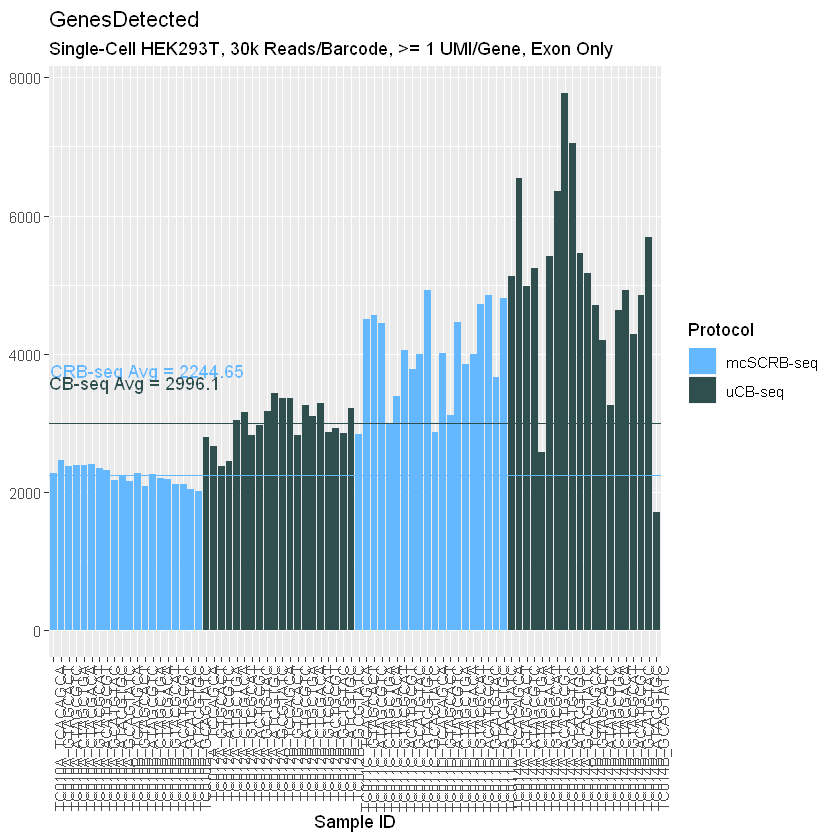

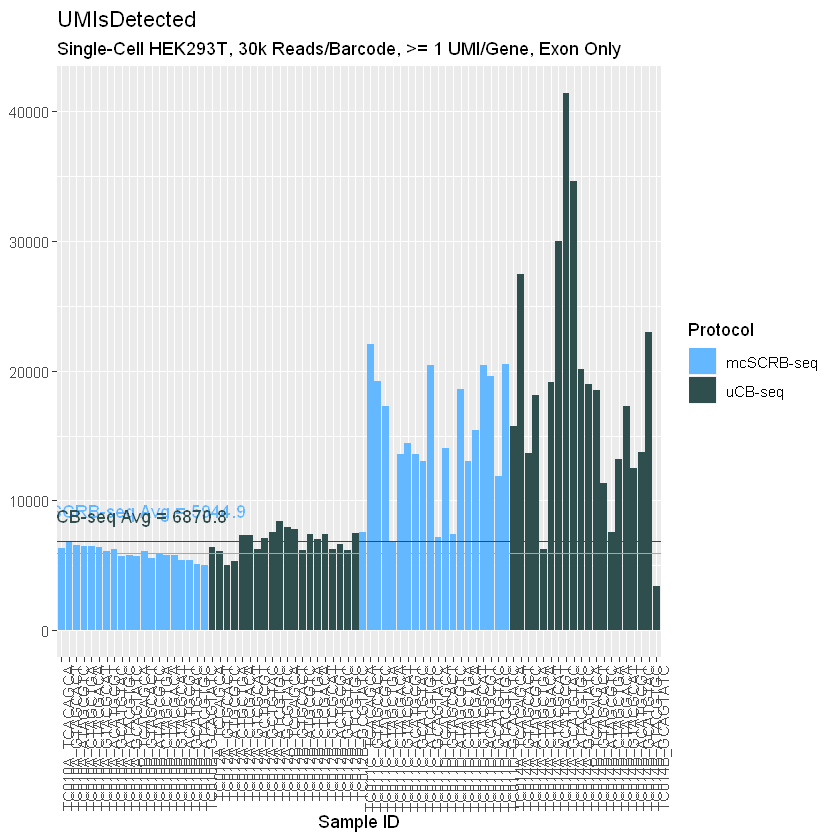

In [106]:
PlotQC <- function(strVar){
    ggplot(colData_Tibble, mapping = aes(x = colnames(uCB_PoC), y = eval(parse(text = paste0('colData_Tibble$', 
            strVar))), fill = as.character(Format))) +
    scale_fill_manual(values = c('steelblue1', 'darkslategray'), name = 'Protocol') +
    geom_bar(stat = "identity") +
    scale_y_continuous(limits = c(0, NA)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),axis.title.y=element_blank())+
    ggtitle(strVar, 'Single-Cell HEK293T, 30k Reads/Barcode, >= 1 UMI/Gene, Exon Only') +
    xlab('Sample ID') +
    ylab(strVar) +
    scale_x_discrete(limits=samplesList) + # keep the order of the x axis
    geom_hline(yintercept = eval(parse(text = paste0('mean(colData_Tibble$', strVar, "[1:20])"))), color="steelblue1") +
    geom_hline(yintercept = eval(parse(text = paste0('mean(colData_Tibble$', strVar, "[21:40])"))), color="darkslategray") +
    annotate("text", x = samplesList[11], y = eval(parse(text = paste0('max(colData_Tibble$', strVar, "[1:40]) * 1.10"))), 
            label = paste0("mcSCRB-seq Avg = ", eval(parse(text = paste0('signif(mean(colData_Tibble$', strVar, "[1:20]), digits = 6)")))),
            color = 'steelblue1') + 
    annotate("text", x = samplesList[11], y = eval(parse(text = paste0('max(colData_Tibble$', strVar, "[1:40]) * 1.05"))), 
            label = paste0("uCB-seq Avg = ", eval(parse(text = paste0('signif(mean(colData_Tibble$', strVar, "[21:40]), digits = 6)")))),
            color = 'darkslategray') 
}

qc_to_plot <- c(names(colData_Tibble[-c(1, 2, 3, 4)]))
lapply(qc_to_plot,PlotQC)

_____

# CV vs. Expression Level

In [107]:
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

In [109]:
# Make summaryTibbleWide
# Remove negative controls if not already removed (note: total counts may include neg if not pre-removed)
summaryTibbleWide <- umiTibble
# Gathering UMI Count by protocol
colnames(summaryTibbleWide)[colnames(summaryTibbleWide)=="ucbtrUMICount"] <- "uCBTotalRNA"
colnames(summaryTibbleWide)[colnames(summaryTibbleWide)=="ucbscUMICount"] <- "uCBSingleCell"
colnames(summaryTibbleWide)[colnames(summaryTibbleWide)=="mctrUMICount"] <- "mcSCRBTotalRNA"
colnames(summaryTibbleWide)[colnames(summaryTibbleWide)=="mcscUMICount"] <- "mcSCRBSingleCell"

# Adding CV by protocol
summaryTibbleWide$uCBTotalRNA_CV <- (rowSds(as.matrix(dplyr::select(umiTibble, contains('TC012'))), na.rm=TRUE) / 
                               rowMeans(dplyr::select(umiTibble, contains('TC012')), na.rm=TRUE))
summaryTibbleWide$uCBSingleCell_CV <- (rowSds(as.matrix(dplyr::select(umiTibble, contains('TC014'))), na.rm=TRUE) / 
                                rowMeans(dplyr::select(umiTibble, contains('TC014')), na.rm=TRUE))
summaryTibbleWide$mcSCRBSingleCell_CV <- (rowSds(as.matrix(dplyr::select(umiTibble, contains('TC011'))), na.rm=TRUE) / 
                                rowMeans(dplyr::select(umiTibble, contains('TC011')), na.rm=TRUE))
summaryTibbleWide$mcSCRBTotalRNA_CV <- (rowSds(as.matrix(dplyr::select(umiTibble, contains('TC010'))), na.rm=TRUE) / 
                                rowMeans(dplyr::select(umiTibble, contains('TC010')), na.rm=TRUE))
summaryTibbleWide$TotalRNADiff_CV <- summaryTibbleWide$uCBTotalRNA_CV - summaryTibbleWide$mcSCRBTotalRNA_CV

# Adding Mean by protocol
summaryTibbleWide$uCBTotalRNA_Mean <- rowMeans(dplyr::select(umiTibble, contains('TC012')), na.rm=TRUE)
summaryTibbleWide$uCBSingleCell_Mean <- rowMeans(dplyr::select(umiTibble, contains('TC014')), na.rm=TRUE)
summaryTibbleWide$mcSCRBSingleCell_Mean <- rowMeans(dplyr::select(umiTibble, contains('TC011')), na.rm=TRUE)
summaryTibbleWide$mcSCRBTotalRNA_Mean <- rowMeans(dplyr::select(umiTibble, contains('TC010')), na.rm=TRUE)

# Adding Gene Detected in uCB Only
summaryTibbleWide$uCBOnlyTotalRNA_Detected <- summaryTibbleWide$uCBTotalRNA_CV
summaryTibbleWide$uCBOnlyTotalRNA_Detected[((summaryTibbleWide$mcSCRBTotalRNA_Mean > 0) | (summaryTibbleWide$uCBTotalRNA_Mean == 0))] <- -1


Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous x-axis"

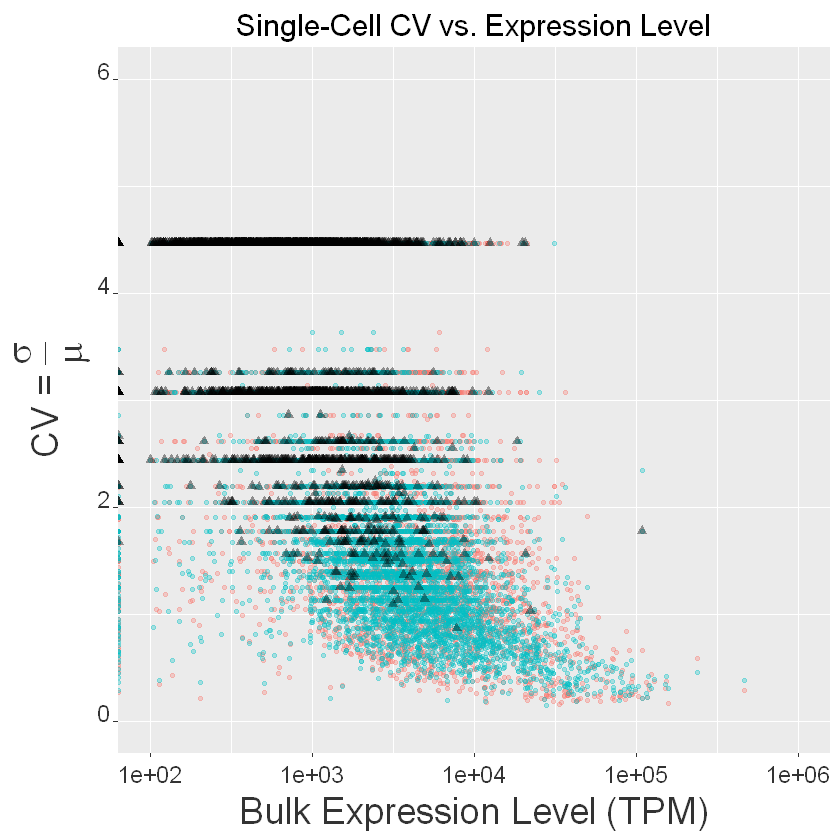

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Transformation introduced infinite values in continuous x-axis"

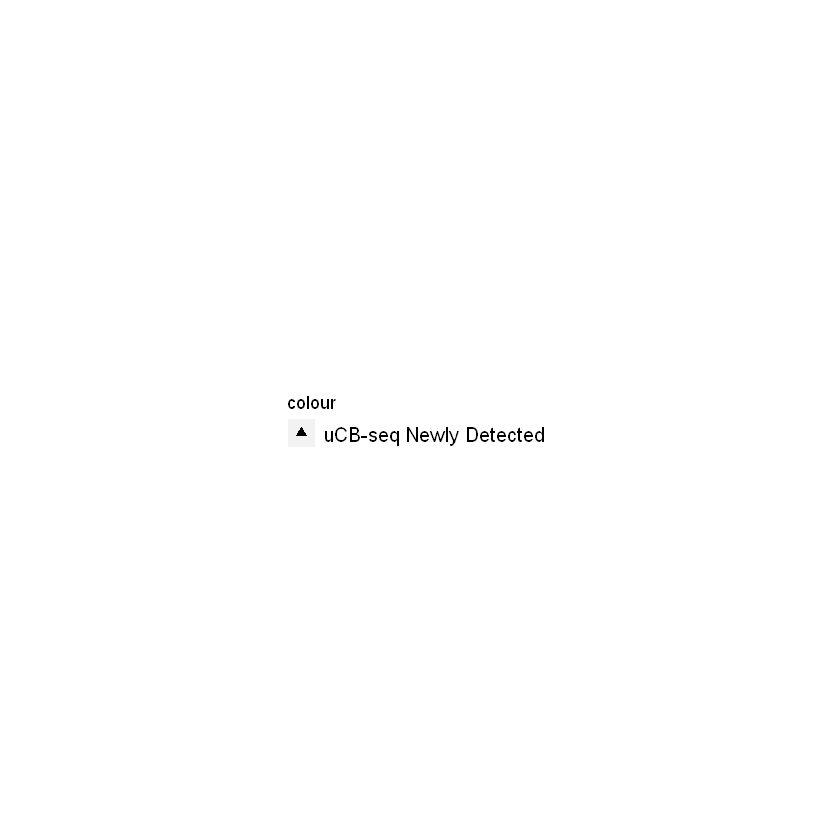

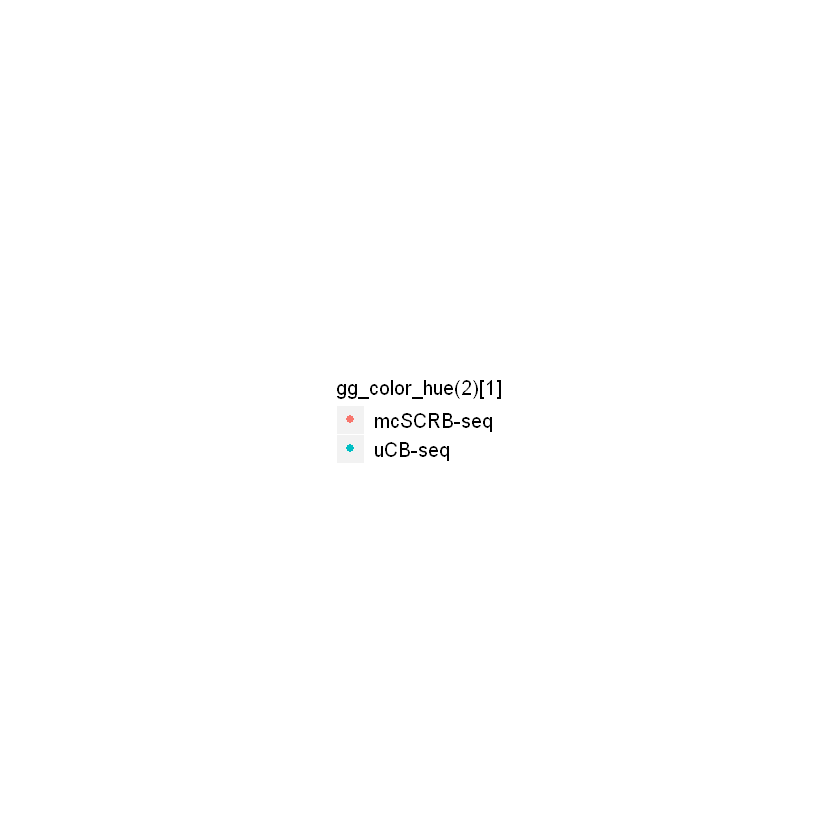

In [110]:
# Plot CV vs. Count plot and Plot for Legend
ggplot(summaryTibbleWide) +
geom_point(aes(x = Bulk, y = mcSCRBTotalRNA_CV), color= gg_color_hue(2)[1], alpha = 0.3, size = 1, na.rm = TRUE) +
geom_point(aes(x = Bulk, y = uCBTotalRNA_CV), color= gg_color_hue(2)[2], alpha = 0.3,  size = 1, na.rm = TRUE) +
geom_point(aes(x = Bulk, y = uCBOnlyTotalRNA_Detected), color='black', alpha = 0.4, size = 2, shape = 17, na.rm = TRUE) +
scale_x_continuous(trans = 'log10', limits=c(100, 1000000)) +
scale_y_continuous(limits = c(0,6)) +
labs(
    title = "Single-Cell CV vs. Expression Level", 
     x = expression(paste('Bulk Expression Level (TPM)')), 
     y = expression(paste('CV = ', frac(sigma, mu))))  + 
# scale_color_manual(values=c(gg_color_hue(2)[2], gg_color_hue(2)[1], 'black'), labels= c("uCB-seq", "mcSCRB-seq", "uCB-seq Newly Detected")) +
# scale_shape_manual(labels=c("New Gene"), values = '17') +
# guides(shape = FALSE,
#          colour = guide_legend(override.aes = list(color = c(gg_color_hue(2)[1], gg_color_hue(2)[2], 'black'), 
#                                                    alpha = c(1,1,1)))) +
# scale_color_manual(values=c(gg_color_hue(2)[1], gg_color_hue(2)[2])) + 
# Set Text Sizes and Fonts
theme(axis.text.x = element_text(color = "grey20", size = 14, angle = 0, hjust = .5, vjust = .5, face = "plain"),
      axis.text.y = element_text(color = "grey20", size = 14, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
      axis.title.x = element_text(color = "grey20", size = 22, angle = 0, hjust = .5, vjust = 0, face = "plain"),
      axis.title.y = element_text(color = "grey20", size = 22, angle = 90, hjust = .5, vjust = .5, face = "plain"),
      plot.title = element_text(color = "black", size = 18, angle = 0, hjust = .5, vjust = .5, face = "plain"),
      legend.title = element_text(size = 12, hjust = 0.5, vjust = 0.5), 
      legend.text = element_text(size = 12))

# Set Canvas dimensions
# coord_fixed(ratio = 3.5)


# Create Legends
# --------------------------------------------------
my_hist <- ggplot(summaryTibbleWide) +
geom_point(aes(x = Bulk, y = uCBOnlyTotalRNA_Detected, color='black'), alpha = 0.4, size = 2, shape = 17, na.rm = TRUE) +
scale_x_continuous(trans = 'log10', limits=c(100, 1000000)) +
scale_y_continuous(limits = c(0,6)) +
scale_color_manual(values=c('black'), labels= c("uCB-seq Newly Detected")) +
scale_shape_manual(labels=c("New Gene"), values = '17') +
guides(shape = FALSE,
         colour = guide_legend(override.aes = list(color = c('black'), 
                                                   alpha = c(1)))) +
# Set Text Sizes and Fonts
theme(legend.text = element_text(size = 12))
legend <- cowplot::get_legend(my_hist)
grid.newpage()
grid.draw(legend)

my_hist <- ggplot(summaryTibbleWide) +
geom_point(aes(x = Bulk, y = mcSCRBTotalRNA_CV, color= gg_color_hue(2)[1]), alpha = 0.3, size = 1, na.rm = TRUE) +
geom_point(aes(x = Bulk, y = uCBTotalRNA_CV, color= gg_color_hue(2)[2]), alpha = 0.3,  size = 1, na.rm = TRUE) +
scale_x_continuous(trans = 'log10', limits=c(100, 1000000)) +
scale_y_continuous(limits = c(0,6)) +
scale_color_manual(values=c(gg_color_hue(2)[1], gg_color_hue(2)[2]), labels= c("mcSCRB-seq", "uCB-seq")) +
guides(shape = FALSE,
         colour = guide_legend(override.aes = list(color = c(gg_color_hue(2)[1], gg_color_hue(2)[2]), 
                                                   alpha = c(1, 1), size = c(2,2)))) +
# Set Text Sizes and Fonts
theme(legend.title = element_text(size = 12, hjust = 0.5, vjust = 0.5), legend.text = element_text(size = 12))
legend <- cowplot::get_legend(my_hist)
grid.newpage()
grid.draw(legend)

In [111]:
# Remove all rows with NA values
# summaryTibbleWide_noNA <- summaryTibbleWide[-which(is.na(summaryTibbleWide$TotalRNADiff_CV)),]

summaryTibbleWide_noNA <- summaryTibbleWide[which(is.finite(summaryTibbleWide$mcSCRBSingleCell_CV)),]
summaryTibbleWide_noNA <- summaryTibbleWide_noNA[which(is.finite(summaryTibbleWide_noNA$uCBSingleCell_CV)),]
# summaryTibbleWide_noNA <- summaryTibbleWide[-which(is.na(summaryTibbleWide$mcSCRBTotalRNA_CV)),]
# summaryTibbleWide_noNA <- summaryTibbleWide[-which(is.na(summaryTibbleWide$TotalRNADiff_CV)),]
# summaryTibbleWide_noNA <- summaryTibbleWide[-which(summaryTibbleWide$Bulk == 0),]
# summaryTibbleWide_noNA <- summaryTibbleWide[-which(is.na(summaryTibbleWide$mcscCV)),]
# summaryTibbleWide_noNA <- summaryTibbleWide[-which(summaryTibbleWide$AllSCMean == 0),]

In [112]:
summaryTibbleWide_noNA

Ensembl ID,Gene Symbol,Biotype,Description,MaxLen,MinLen,MeanLen,MedianLen,MaxGC,MinGC,...,uCBTotalRNA_CV,uCBSingleCell_CV,mcSCRBSingleCell_CV,mcSCRBTotalRNA_CV,TotalRNADiff_CV,uCBTotalRNA_Mean,uCBSingleCell_Mean,mcSCRBSingleCell_Mean,mcSCRBTotalRNA_Mean,uCBOnlyTotalRNA_Detected
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,TSPAN6,protein_coding,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],9996,4149,6774.800,6550.0,0.4393098,0.4043617,...,1.1571289,0.7487013,0.6400692,1.223518,-6.638857e-02,1.25,2.83333333,2.1250,0.85,-1.000000
ENSG00000000419,DPM1,protein_coding,"dolichyl-phosphate mannosyltransferase subunit 1, catalytic [Source:HGNC Symbol;Acc:HGNC:3005]",23689,10966,21330.833,23630.5,0.4027697,0.3984969,...,1.5201337,1.0671859,0.7452328,1.235007,2.851270e-01,0.65,1.27777778,1.3750,0.70,-1.000000
ENSG00000000457,SCYL3,protein_coding,SCY1 like pseudokinase 3 [Source:HGNC Symbol;Acc:HGNC:19285],44322,34834,39122.800,39757.0,0.4091979,0.3994137,...,4.4721360,1.2899091,2.7325202,NaN,NaN,0.05,0.38888889,0.1250,0.00,4.472136
ENSG00000000460,C1orf112,protein_coding,chromosome 1 open reading frame 112 [Source:HGNC Symbol;Acc:HGNC:25565],191079,9305,53700.000,57117.0,0.3923770,0.3692246,...,3.0779351,1.5857824,1.9266551,4.472136,-1.394201e+00,0.10,0.44444444,0.3125,0.05,-1.000000
ENSG00000001036,FUCA2,protein_coding,"fucosidase, alpha-L- 2, plasma [Source:HGNC Symbol;Acc:HGNC:4008]",16880,5171,10599.000,9746.0,0.4088184,0.3968602,...,1.8346177,1.1222084,1.2649111,1.398173,4.364448e-01,0.45,1.94444444,0.5000,0.35,-1.000000
ENSG00000001084,GCLC,protein_coding,glutamate-cysteine ligase catalytic subunit [Source:HGNC Symbol;Acc:HGNC:4311],94506,638,30029.800,32045.0,0.4278549,0.3963229,...,2.2004784,1.0289915,1.6510378,4.472136,-2.271658e+00,0.25,1.16666667,0.3750,0.05,-1.000000
ENSG00000001167,NFYA,protein_coding,nuclear transcription factor Y subunit alpha [Source:HGNC Symbol;Acc:HGNC:7804],27032,24968,26000.000,26000.0,0.4006328,0.4000074,...,1.6775513,1.5400535,1.4380637,4.472136,-2.794585e+00,0.35,0.55555556,0.4375,0.05,-1.000000
ENSG00000001460,STPG1,protein_coding,sperm tail PG-rich repeat containing 1 [Source:HGNC Symbol;Acc:HGNC:28070],59930,869,28746.333,22681.0,0.5364985,0.3626430,...,4.4721360,1.3853222,2.1499354,NaN,NaN,0.05,0.44444444,0.1875,0.00,4.472136
ENSG00000001461,NIPAL3,protein_coding,NIPA like domain containing 3 [Source:HGNC Symbol;Acc:HGNC:25233],57174,4317,31568.571,39012.0,0.4741719,0.4453501,...,2.2004784,1.5626185,2.3094011,3.077935,-8.774566e-01,0.25,0.38888889,0.2500,0.10,-1.000000


Warning message:
"Transformation introduced infinite values in continuous x-axis"ERROR while rich displaying an object: Error in `[[<-.data.frame`(`*tmp*`, i, value = c(1, 1)): replacement has 2 rows, data has 3

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_con

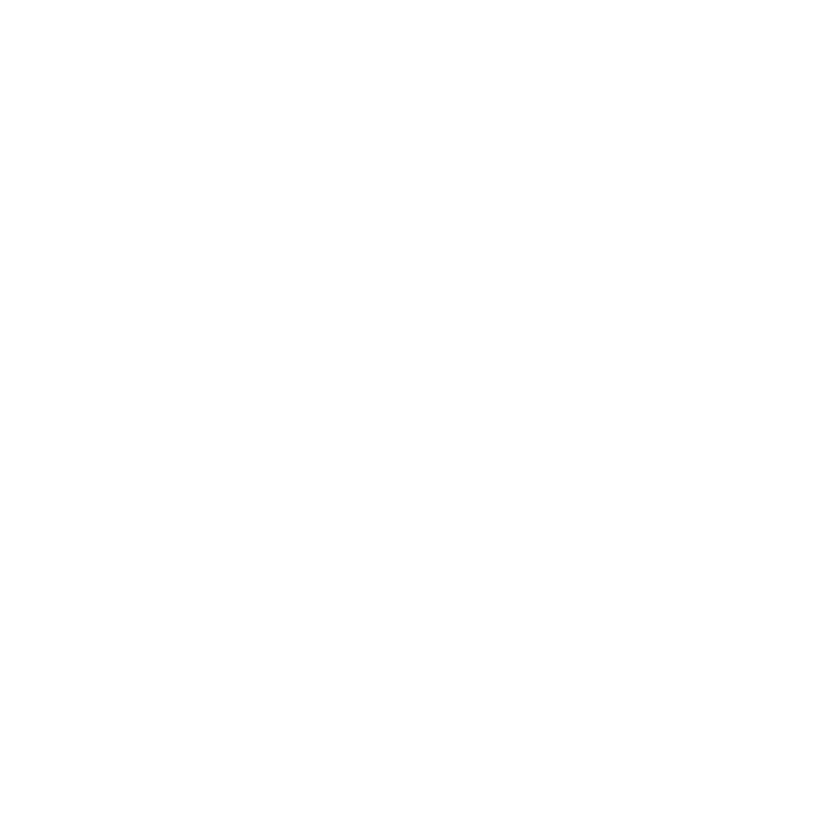

In [36]:
# Plot Delta CV vs. Count plot 
ggplot(summaryTibbleWide_noNA) +
geom_point(aes(x = Bulk, y = TotalRNADiff_CV, color = (TotalRNADiff_CV < 0)), alpha = 0.2,  size = 1, na.rm = TRUE) +
geom_hline(aes(yintercept = 0)) +
scale_x_continuous(trans = 'log10', limits=c(100, 1000000)) +
scale_color_discrete(labels=c("Increase", "Reduction")) +
annotate("text", x = 75000, y = 3.15, hjust = 0.75, 
         label = paste0("Genes with Increased Variation: ", sum(summaryTibbleWide_noNA$TotalRNADiff_CV > 0, na.rm = TRUE)), color = gg_color_hue(2)[1], size = 5) +
annotate("text", x = 75000, y = 2.85, hjust = 0.75, 
         label = paste0("Genes with Decreased Variation: ", sum(summaryTibbleWide_noNA$TotalRNADiff_CV < 0, na.rm = TRUE)), color = gg_color_hue(2)[2], size = 5) +
guides(shape = FALSE, colour = guide_legend(override.aes = list(alpha = c(1,1)))) +
labs(
    x = expression(paste(log[10], '(TPM)')), 
    y = expression(paste(Delta, 'CV = CV(', mu, 'CB) - CV(mcSCRB)')),
    color = expression(paste("CV Change \nwith μCB-seq")))  + 
# Set Text Sizes and Fonts
theme(axis.text.x = element_text(color = "grey20", size = 14, angle = 0, hjust = .5, vjust = .5, face = "plain"),
      axis.text.y = element_text(color = "grey20", size = 14, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
      axis.title.x = element_text(color = "grey20", size = 22, angle = 0, hjust = .5, vjust = 0, face = "plain"),
      axis.title.y = element_text(color = "grey20", size = 22, angle = 90, hjust = .5, vjust = .5, face = "plain"),
      plot.title = element_text(color = "black", size = 18, angle = 0, hjust = .5, vjust = .5, face = "plain"),
      legend.title = element_text(size = 12, hjust = 0.5, vjust = 0.5), 
      legend.text = element_text(size = 12))

# Set Canvas dimensions
# coord_fixed(ratio = 3.5)

_____

,TC012A_TCCAGCA,TC012A_GTGCACT,TC012A_ATGCGTC,TC012A_CTGCTGA,TC012A_CTCGACA,TC012A_GTCGCAT,TC012A_ACTGCGT,TC012A_GCTGTAC,TC012A_ATCGTGC,TC012A_GCGTATC,...,TC014A_GCAGTATC,TC014B_TCACAGCA,TC014B_GTAGCACT,TC014B_ATAGCGTC,TC014B_CTAGCTGA,TC014B_CTACGACA,TC014B_GTACGCAT,TC014B_ACATGCGT,TC014B_GCATGTAC,TC014B_ATACGTGC
TC012A_TCCAGCA,1.00000,0.84256,0.82711,0.86398,0.87872,0.86955,0.85512,0.86524,0.86962,0.88054,...,0.86506,0.84639,0.76276,0.70349,0.62991,0.75815,0.85989,0.74242,0.68266,0.88486
TC012A_GTGCACT,0.84256,1.00000,0.83745,0.83759,0.82722,0.80729,0.84705,0.86410,0.85337,0.86686,...,0.81654,0.77010,0.66235,0.57980,0.48308,0.65527,0.80377,0.62356,0.56250,0.85664
TC012A_ATGCGTC,0.82711,0.83745,1.00000,0.82373,0.82388,0.79764,0.83627,0.84672,0.82566,0.84014,...,0.81420,0.79452,0.69727,0.63280,0.53427,0.68728,0.80569,0.67464,0.61444,0.85086
TC012A_CTGCTGA,0.86398,0.83759,0.82373,1.00000,0.87601,0.86046,0.85543,0.85751,0.85618,0.86470,...,0.86326,0.84535,0.76616,0.69116,0.61794,0.75958,0.85887,0.72932,0.65604,0.88416
TC012A_CTCGACA,0.87872,0.82722,0.82388,0.87601,1.00000,0.88934,0.85819,0.86088,0.86408,0.86396,...,0.88736,0.86961,0.82098,0.73986,0.68495,0.80622,0.88873,0.76944,0.69310,0.88597
TC012A_GTCGCAT,0.86955,0.80729,0.79764,0.86046,0.88934,1.00000,0.84569,0.84863,0.84231,0.85585,...,0.88495,0.86711,0.83239,0.76957,0.71107,0.81893,0.88718,0.78552,0.71836,0.86944
TC012A_ACTGCGT,0.85512,0.84705,0.83627,0.85543,0.85819,0.84569,1.00000,0.86792,0.86330,0.87276,...,0.85743,0.82313,0.72996,0.66054,0.57200,0.73064,0.83935,0.69091,0.62711,0.88274
TC012A_GCTGTAC,0.86524,0.86410,0.84672,0.85751,0.86088,0.84863,0.86792,1.00000,0.87382,0.89228,...,0.84674,0.79742,0.69566,0.63881,0.54326,0.70553,0.84223,0.67426,0.62231,0.88137
TC012A_ATCGTGC,0.86962,0.85337,0.82566,0.85618,0.86408,0.84231,0.86330,0.87382,1.00000,0.88151,...,0.85585,0.80749,0.70430,0.64020,0.55613,0.71880,0.84026,0.67746,0.61542,0.88521
TC012A_GCGTATC,0.88054,0.86686,0.84014,0.86470,0.86396,0.85585,0.87276,0.89228,0.88151,1.00000,...,0.85045,0.80088,0.69516,0.64012,0.54945,0.70750,0.83972,0.68191,0.63005,0.88305


Warning message in heatmap.2(x = uCBSamples, col = colors, symm = TRUE, Colv = NA, :
"Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram."Warning message in heatmap.2(x = uCBSamples, col = colors, symm = TRUE, Colv = NA, :
"Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram."Warning message in plot.window(...):
""key.xlab.size" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""key.xlab.size" is not a graphical parameter"Warning message in title(...):
""key.xlab.size" is not a graphical parameter"Warning message in heatmap.2(x = uCBSamples, col = colors, symm = TRUE, Colv = NA, :
"Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram."Warning message in heatmap.2(x = uCBSamples, col = colors, symm = TRUE, Colv = NA, :
"Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram."

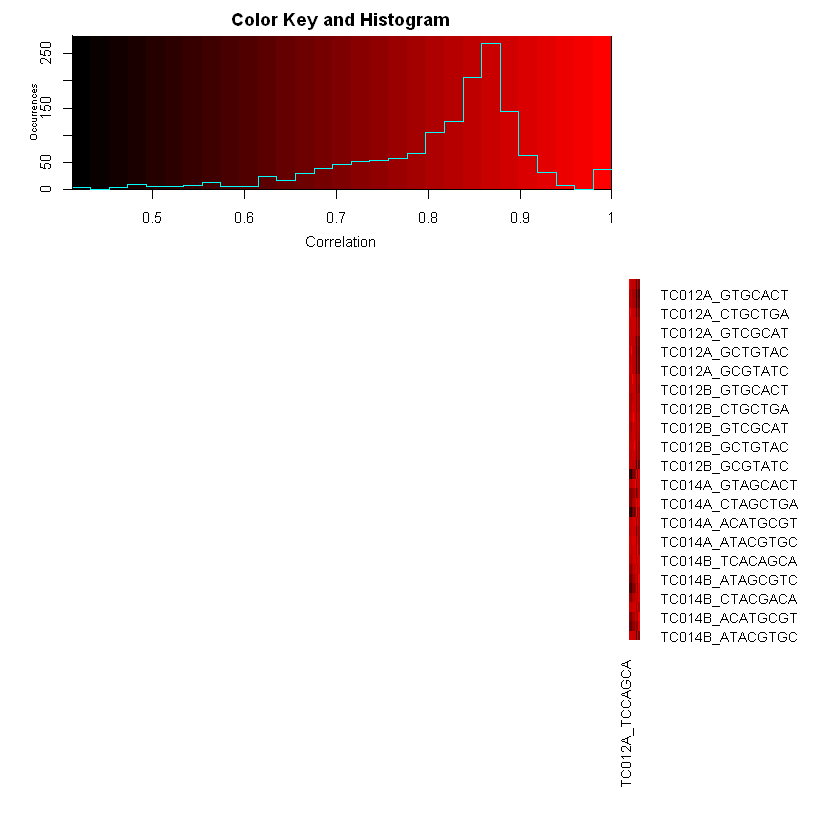

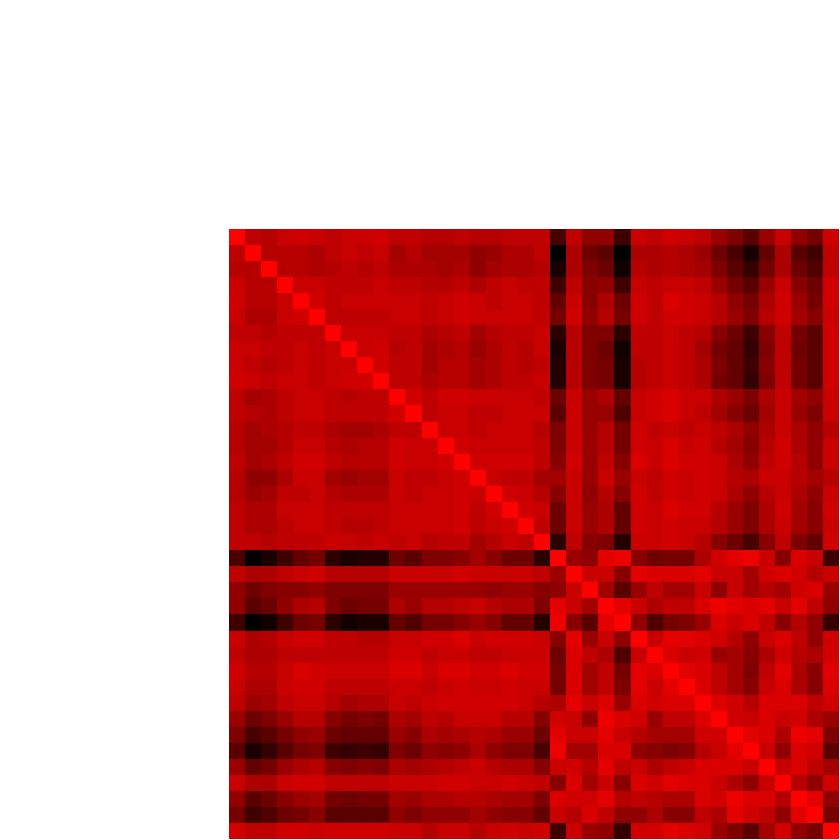

In [117]:
# Correlate uCB Samples
uCBTibble <- bind_cols(dplyr::select(umiTibble, contains('TC012')), dplyr::select(umiTibble, contains('TC014')))
uCBSamples <- cor(uCBTibble, method = 'pearson')
round(uCBSamples, 5)
setwd('C:/Users/tyler/Desktop')
write_csv(as.data.frame(uCBSamples),'uCBSamples.csv')
# mean(uCBSamples[1:20,1:20])

colors <- colorRampPalette(c("black","red"))(29)
heatmap.2(x = uCBSamples, col = colors, symm = TRUE, Colv = NA, Rowv = NA, revC = FALSE, margins = c(10,10), trace = 'none',
         key=TRUE, lhei=c(2,4), lwid=c(3,1), keysize=2, 
         key.title = 'Color Key and Histogram',
         key.xlab = 'Correlation',
         key.ylab = 'Occurrences',
         key.xlab.size = 12)
heatmap.2(x = uCBSamples, col = colors, symm = TRUE, Colv = NA, Rowv = NA, revC = FALSE, margins = c(0,0), trace = 'none', key=FALSE)

________

## Plots of Detection Probability vs. GC Content (from TC010) 

In [37]:
# # Histogram of GC Content
# ggplot(summaryTibbleWide) + 
# geom_histogram(aes(x = MedianGC), binwidth = 0.05)

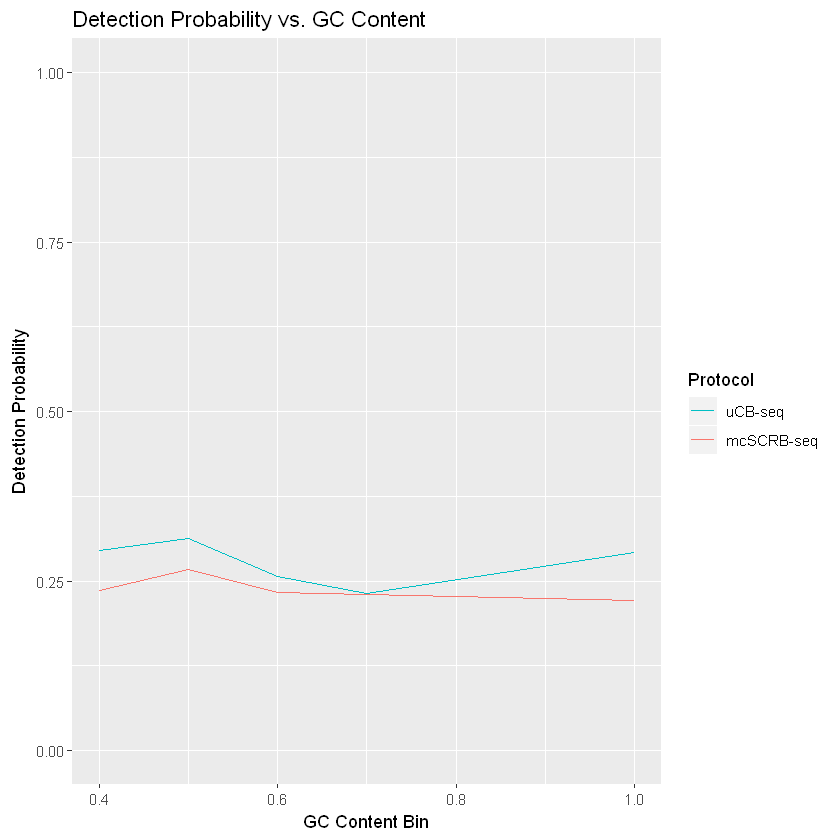

In [38]:
# Plot of Detection Probability Within Protocol vs. GC Content 
# (e.g. genes not detected in mcSCRB-seq (prob = 0) are not counted towards mean detection probability for a bin)

gcMatrix <- matrix(, nrow = 5, ncol = 3)

i <- 1
xPrev <- 0
for (x in (c(0.4, 0.5, 0.6, 0.7, 1.0))) {
    gcMatrix[i, 1] <- x
    gcMatrix[i, 2] <- mean(summaryTibbleWide[which((summaryTibbleWide$MedianGC < x) & (summaryTibbleWide$MedianGC > xPrev) & (summaryTibbleWide$mctrDetection > 0)),]$mctrDetection)
    gcMatrix[i, 3] <- mean(summaryTibbleWide[which((summaryTibbleWide$MedianGC < x) & (summaryTibbleWide$MedianGC > xPrev) & (summaryTibbleWide$ucbtrDetection > 0)),]$ucbtrDetection)
    i <- i + 1
    xPrev <- x
}

# Plotting
ggplot() +
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,2], color = gg_color_hue(2)[1])) + 
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,3], color = gg_color_hue(2)[2])) + 
ylim(0, 1)  + 
labs(title = "Detection Probability vs. GC Content", 
     x = expression(paste('GC Content Bin')), 
     y = expression(paste('Detection Probability')), 
     color = "Protocol")  + 
scale_color_manual(values=c(gg_color_hue(2)[2], gg_color_hue(2)[1]), labels= c("uCB-seq", "mcSCRB-seq")) +
guides(shape = FALSE,
         colour = guide_legend(override.aes = list(color = c(gg_color_hue(2)[2], gg_color_hue(2)[1]), 
                                                   alpha = c(1,1))))

## Plots of Detection Probability vs. Length

In [39]:
# # Histogram of Gene Length
# ggplot(summaryTibbleWide) + 
# geom_histogram(aes(x = MedianLen), binwidth = 1000)

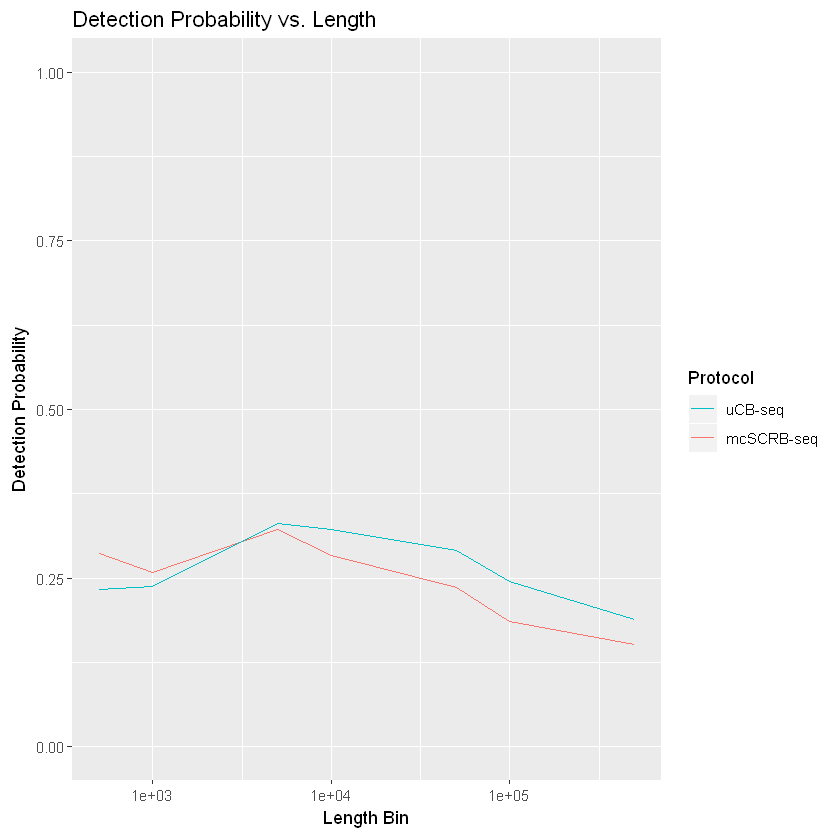

In [40]:
# Plot of Detection Probability Within Protocol vs. Length
# (e.g. genes not detected in mcSCRB-seq (prob = 0) are not counted towards mean detection probability for a bin)

gcMatrix <- matrix(, nrow = 7, ncol = 3)

i <- 1
xPrev <- 0
for (x in (c(500, 1000, 5000, 10000, 50000, 100000, 500000))) {
    gcMatrix[i, 1] <- x
    gcMatrix[i, 2] <- mean(summaryTibbleWide[which((summaryTibbleWide$MedianLen < x) & (summaryTibbleWide$MedianLen > xPrev) & (summaryTibbleWide$mctrDetection > 0)),]$mctrDetection)
    gcMatrix[i, 3] <- mean(summaryTibbleWide[which((summaryTibbleWide$MedianLen < x) & (summaryTibbleWide$MedianLen > xPrev) & (summaryTibbleWide$ucbtrDetection > 0)),]$ucbtrDetection)
    i <- i + 1
    xPrev <- x
}

# Plotting
ggplot() +
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,2], color = gg_color_hue(2)[1])) + 
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,3], color = gg_color_hue(2)[2])) + 
ylim(0, 1)  + 
scale_x_continuous(trans = 'log10') +
labs(title = "Detection Probability vs. Length", 
     x = expression(paste('Length Bin')), 
     y = expression(paste('Detection Probability')), 
     color = "Protocol")  + 
scale_color_manual(values=c(gg_color_hue(2)[2], gg_color_hue(2)[1]), labels= c("uCB-seq", "mcSCRB-seq")) +
guides(shape = FALSE,
         colour = guide_legend(override.aes = list(color = c(gg_color_hue(2)[2], gg_color_hue(2)[1]), 
                                                   alpha = c(1,1))))

_____

## Plots of Reproducible Detection Probability vs. Abundance

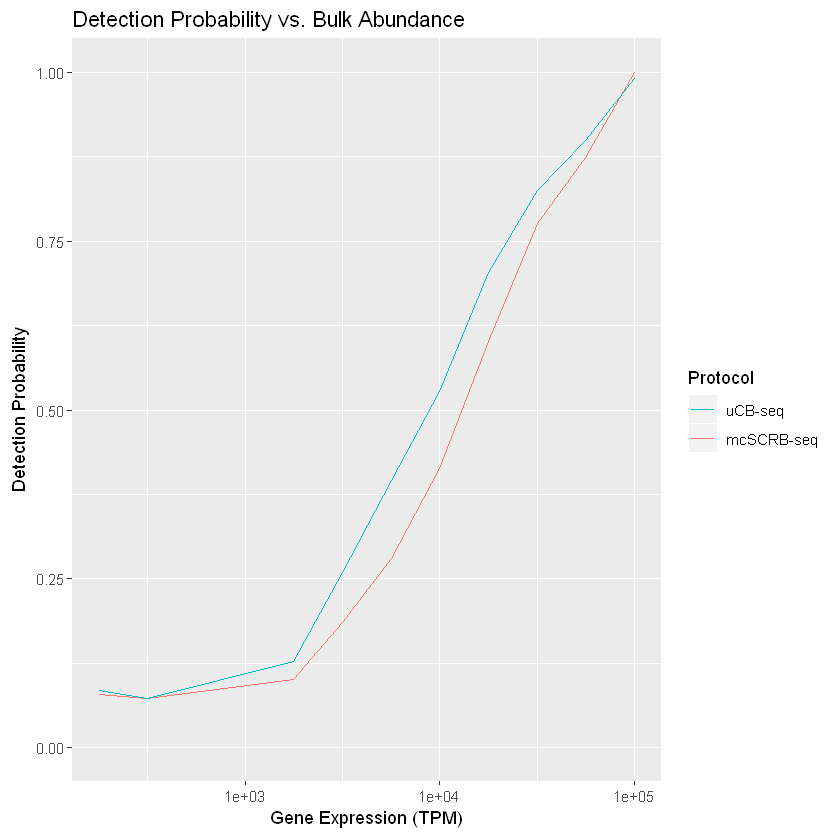

In [41]:
# Plot of Detection Probability Within Protocol vs. Abundance
# (e.g. genes not detected in mcSCRB-seq (prob = 0) are not counted towards mean detection probability for a bin)

gcMatrix <- matrix(, nrow = 10, ncol = 3)

i <- 1
xPrev <- 10^2
for (x in (c(10^2.25, 10^2.5, 10^3.25, 10^3.5, 10^3.75, 10^4, 10^4.25, 10^4.5, 10^4.75, 10^5))) {
    gcMatrix[i, 1] <- x
    gcMatrix[i, 2] <- mean(summaryTibbleWide[which((summaryTibbleWide$Bulk < x) & (summaryTibbleWide$Bulk > xPrev) & (summaryTibbleWide$mcscPairDetection > 0)),]$mcscPairDetection)
    gcMatrix[i, 3] <- mean(summaryTibbleWide[which((summaryTibbleWide$Bulk < x) & (summaryTibbleWide$Bulk > xPrev) & (summaryTibbleWide$ucbscPairDetection > 0)),]$ucbscPairDetection)
    i <- i + 1
    xPrev <- x
}

# Plotting
ggplot() +
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,2], color = gg_color_hue(2)[1])) + 
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,3], color = gg_color_hue(2)[2])) + 
ylim(0, 1)  + 
scale_x_continuous(trans = 'log10') +
labs(title = "Detection Probability vs. Bulk Abundance", 
     x = expression(paste('Gene Expression (TPM)')), 
     y = expression(paste('Detection Probability')), 
     color = "Protocol")  + 
scale_color_manual(values=c(gg_color_hue(2)[2], gg_color_hue(2)[1]), labels= c("uCB-seq", "mcSCRB-seq")) +
guides(shape = FALSE,
         colour = guide_legend(override.aes = list(color = c(gg_color_hue(2)[2], gg_color_hue(2)[1]), 
                                                   alpha = c(1,1))))

___

## Plots of CV vs. Abundance 

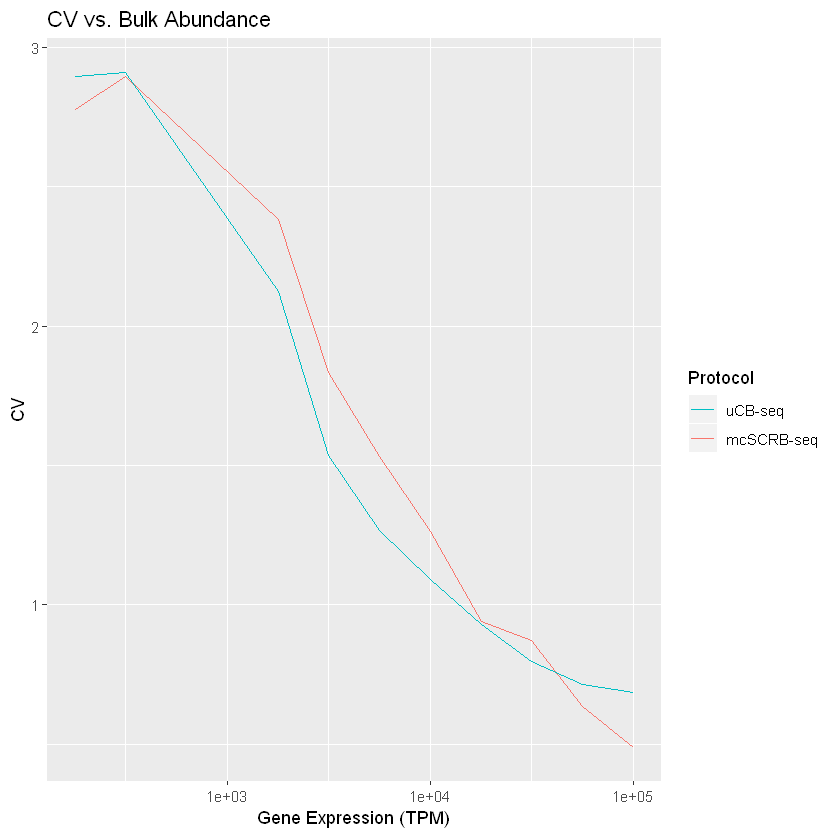

In [88]:
# Plot of CV Within Protocol vs. Abundance

gcMatrix <- matrix(, nrow = 10, ncol = 3)

i <- 1
xPrev <- 10^2
for (x in (c(10^2.25, 10^2.5, 10^3.25, 10^3.5, 10^3.75, 10^4, 10^4.25, 10^4.5, 10^4.75, 10^5))) {
    gcMatrix[i, 1] <- x
    gcMatrix[i, 2] <- mean(summaryTibbleWide_noNA[which((summaryTibbleWide_noNA$Bulk < x) & (summaryTibbleWide_noNA$Bulk > xPrev) & (summaryTibbleWide_noNA$mcSCRBSingleCell_CV > 0)),]$mcSCRBSingleCell_CV)
    gcMatrix[i, 3] <- mean(summaryTibbleWide_noNA[which((summaryTibbleWide_noNA$Bulk < x) & (summaryTibbleWide_noNA$Bulk > xPrev) & (summaryTibbleWide_noNA$uCBSingleCell_CV > 0)),]$uCBSingleCell_CV)
    i <- i + 1
    xPrev <- x
}

# Plotting
ggplot() +
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,2], color = gg_color_hue(2)[1])) + 
geom_line(aes(x = gcMatrix[,1], y = gcMatrix[,3], color = gg_color_hue(2)[2])) + 
scale_x_continuous(trans = 'log10') +
labs(title = "CV vs. Bulk Abundance", 
     x = expression(paste('Gene Expression (TPM)')), 
     y = expression(paste('CV')), 
     color = "Protocol")  + 
scale_color_manual(values=c(gg_color_hue(2)[2], gg_color_hue(2)[1]), labels= c("uCB-seq", "mcSCRB-seq")) +
guides(shape = FALSE,
         colour = guide_legend(override.aes = list(color = c(gg_color_hue(2)[2], gg_color_hue(2)[1]), 
                                                   alpha = c(1,1))))

___

## Venn Diagram

In [86]:
umiTibble$TotalRNASum <- rowSums(uCBTibble[,5:4+(length(samplesList)/4)])

In [92]:
# Assign values for overlapping/unique genes to each condition
uniqueBulk          <- sum(uCBTibble$TotalRNASum > 0 & uCBTibble$TC014B_GTACGCAT == 0)
uniqueSingleCell    <- sum(uCBTibble$TotalRNASum == 0 & uCBTibble$TC014B_GTACGCAT > 0)
overlapBulkCell     <- sum(uCBTibble$TotalRNASum > 0 & uCBTibble$TC014B_GTACGCAT > 0)

uniqueBulk
uniqueSingleCell
overlapBulkCell
print('Check')
sum(uCBTibble$TC014B_GTACGCAT > 0)
sum(uniqueSingleCell,overlapBulkCell)

[1] 5662

[1] 258

[1] 4661

[1] "Check"


[1] 4919

[1] 4919

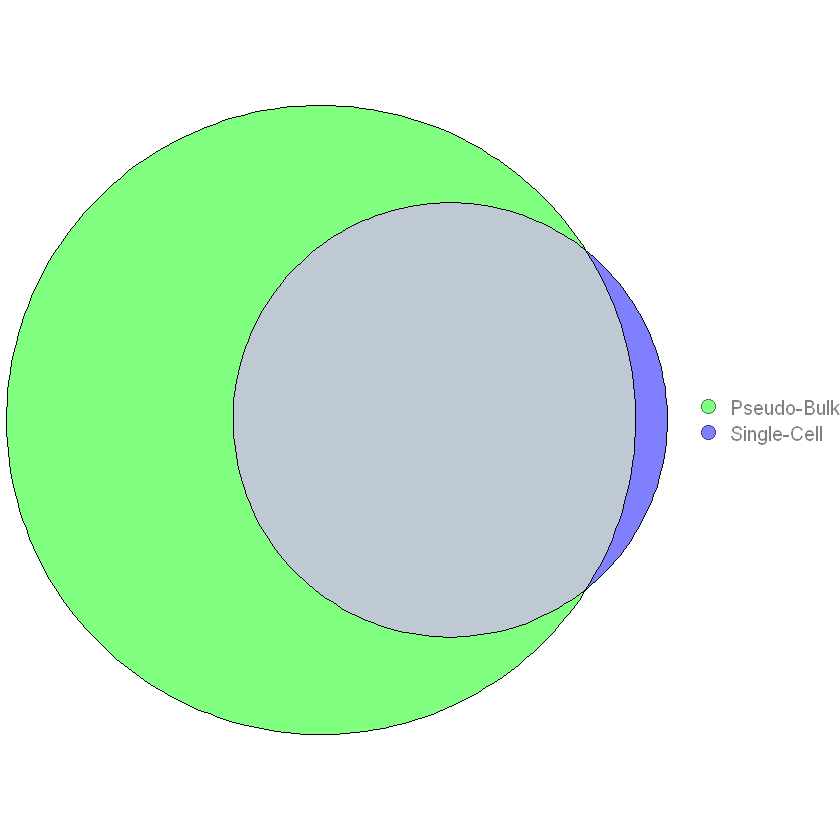

In [95]:
# Plot Euler Diagram
plot(eulerr::euler(c(Bulk = (uniqueBulk), 
                     SingleCell = (uniqueSingleCell),
                     "Bulk&SingleCell" = overlapBulkCell),
                     shape = "circle"), 
                     fills = list(fill = c("green", "blue"), alpha = 0.5),
                     legend = list(labels = c("Pseudo-Bulk", "Single-Cell")))

________

# Total RNA Downsampling Analysis

In [118]:
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC010Final/')
TC010A <- readRDS('TC010A.dgecounts.rds')
TC010B <- readRDS('TC010B.dgecounts.rds')
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC012Final/')
TC012A <- readRDS('TC012A.dgecounts.rds')
TC012B <- readRDS('TC012B.dgecounts.rds')

In [35]:
names(TC012A$umicount$exon$downsampling)

[1] "downsampled_100000" "downsampled_75000"  "downsampled_50000" 
 [4] "downsampled_40000"  "downsampled_30000"  "downsampled_20000" 
 [7] "downsampled_10000"  "downsampled_7500"   "downsampled_5000"  
[10] "downsampled_2500"   "downsampled_1000"

In [37]:
samples <- c('TC010A', 'TC010B', 'TC012A', 'TC012B')
barcodes <- c('TCACAGCA', 'GTAGCACT', 'ATAGCGTC', 'CTAGCTGA','CTACGACA', 'GTACGCAT', 'ACATGCGT', 'GCATGTAC', 'ATACGTGC', 'GCAGTATC')
barcodes12 <- c('TCCAGCA', 'GTGCACT', 'ATGCGTC', 'CTGCTGA','CTCGACA', 'GTCGCAT', 'ACTGCGT', 'GCTGTAC', 'ATCGTGC', 'GCGTATC')


# Initialize Gene and UMI matrices for all samples at 11 different downsampling values
TC010AGeneMat <- matrix(, nrow = 11, ncol = 10)
TC010AUMIMat <- matrix(, nrow = 11, ncol = 10)
TC010BGeneMat <- matrix(, nrow = 11, ncol = 10)
TC010BUMIMat <- matrix(, nrow = 11, ncol = 10)
TC012AGeneMat <- matrix(, nrow = 11, ncol = 10)
TC012AUMIMat <- matrix(, nrow = 11, ncol = 10)
TC012BGeneMat <- matrix(, nrow = 11, ncol = 10)
TC012BUMIMat <- matrix(, nrow = 11, ncol = 10)

# Define downsampling range to look at as 1M-1k from TC012A
allDepths <- names(TC012A$umicount$exon$downsampling)

for (sample in samples) {
    if (grepl('TC010', sample)) {
        # Name columns and rows of all matrices for easy indexing
        eval(parse(text = paste0('colnames(', sample, 'GeneMat) <- barcodes')))
        eval(parse(text = paste0('rownames(', sample, 'GeneMat) <- allDepths')))
        eval(parse(text = paste0('colnames(', sample, 'UMIMat) <- barcodes')))
        eval(parse(text = paste0('rownames(', sample, 'UMIMat) <- allDepths')))

        eval(parse(text = paste0(sample, 'Depths <- names(', sample, '$umicount$', lookAt, '$downsampling)')))
        for (depth in allDepths) {
            # Check if this specific sample has barcodes with enough reads for specified seq depth
            if (depth %in% eval(parse(text = paste0(sample, 'Depths')))) {
                eval(parse(text = paste0('allowedBarcodes <- colnames(', sample, '$umicount$', lookAt, '$downsampling$', depth, ')')))
                for (barcode in allowedBarcodes) {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"] > 0)')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"])')))
                }
            }
        }
    } else {
        eval(parse(text = paste0('colnames(', sample, 'GeneMat) <- barcodes12')))
        eval(parse(text = paste0('rownames(', sample, 'GeneMat) <- allDepths')))
        eval(parse(text = paste0('colnames(', sample, 'UMIMat) <- barcodes12')))
        eval(parse(text = paste0('rownames(', sample, 'UMIMat) <- allDepths')))

        eval(parse(text = paste0(sample, 'Depths <- names(', sample, '$umicount$', lookAt, '$downsampling)')))
        for (depth in allDepths) {
            # Check if this specific sample has barcodes with enough reads for specified seq depth
            if (depth %in% eval(parse(text = paste0(sample, 'Depths')))) {
                eval(parse(text = paste0('allowedBarcodes12 <- colnames(', sample, '$umicount$', lookAt, '$downsampling$', depth, ')')))
                for (barcode in allowedBarcodes12) {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"] > 0)')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"])')))
                }
            }
        }
    }

}

In [38]:
masterGeneMat <- matrix(, nrow = 11, ncol = 3)
masterUMIMat <- matrix(, nrow = 11, ncol = 3)

# Set column/row names for indexing
colnames(masterGeneMat) <- c('Reads', 'mcSCRB-seq', 'UCB-seq')
rownames(masterGeneMat) <- allDepths
colnames(masterUMIMat) <- c('Reads', 'mcSCRB-seq', 'UCB-seq')
rownames(masterUMIMat) <- allDepths

for (depth in allDepths) {
    # Get substring from end of downsampled_DEPTH as numeric for read count
    masterGeneMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    masterUMIMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    
    # Get average Gene Count for mcSCRB-seq and UCB-seq by summing the counts from each experiment and dividing by 
    # the number of barcodes included in each experiment at that read depth.
    masterGeneMat[depth,'mcSCRB-seq'] <- ((sum(TC010AGeneMat[depth,], na.rm = TRUE) + sum(TC010BGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC010AGeneMat[depth,])) + sum(!is.na(TC010BGeneMat[depth,]))))
    masterUMIMat[depth,'mcSCRB-seq'] <- ((sum(TC010AUMIMat[depth,], na.rm = TRUE) + sum(TC010BUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC010AUMIMat[depth,])) + sum(!is.na(TC010BUMIMat[depth,]))))
    masterGeneMat[depth,'UCB-seq'] <- ((sum(TC012AGeneMat[depth,], na.rm = TRUE) + sum(TC012BGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC012AGeneMat[depth,])) + sum(!is.na(TC012BGeneMat[depth,]))))
    masterUMIMat[depth,'UCB-seq'] <- ((sum(TC012AUMIMat[depth,], na.rm = TRUE) + sum(TC012BUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC012AUMIMat[depth,])) + sum(!is.na(TC012BUMIMat[depth,]))))
}
masterGeneDf <- as.data.frame(masterGeneMat)
masterGeneDf <- melt(masterGeneDf, id=c("Reads"))
colnames(masterGeneDf)[colnames(masterGeneDf) == 'variable'] <- 'Protocol'
colnames(masterGeneDf)[colnames(masterGeneDf) == 'value'] <- 'Genes'

masterUMIDf <- as.data.frame(masterUMIMat)
masterUMIDf <- melt(masterUMIDf, id=c("Reads"))
colnames(masterUMIDf)[colnames(masterUMIDf) == 'variable'] <- 'Protocol'
colnames(masterUMIDf)[colnames(masterUMIDf) == 'value'] <- 'UMIs'

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'


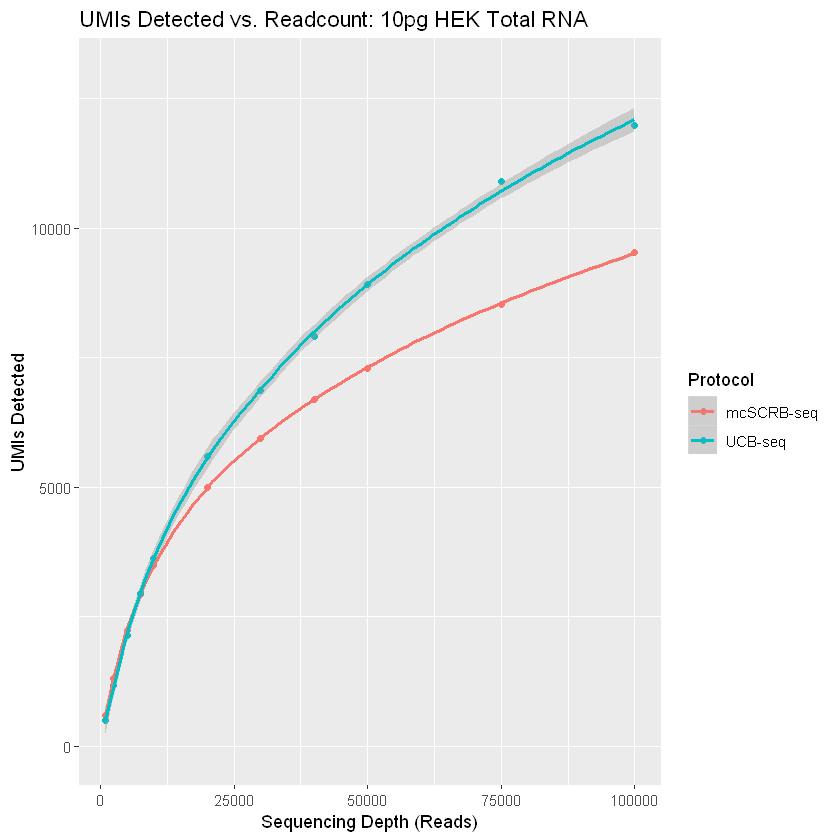

In [47]:
# Plot UMIs Detected

ggplot(masterUMIDf, aes(x = Reads, y = UMIs, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('UMIs Detected') +
ggtitle('UMIs Detected vs. Readcount: 10pg HEK Total RNA') + 
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'UCB-seq')) + 
ylim(-100, 13000)

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'


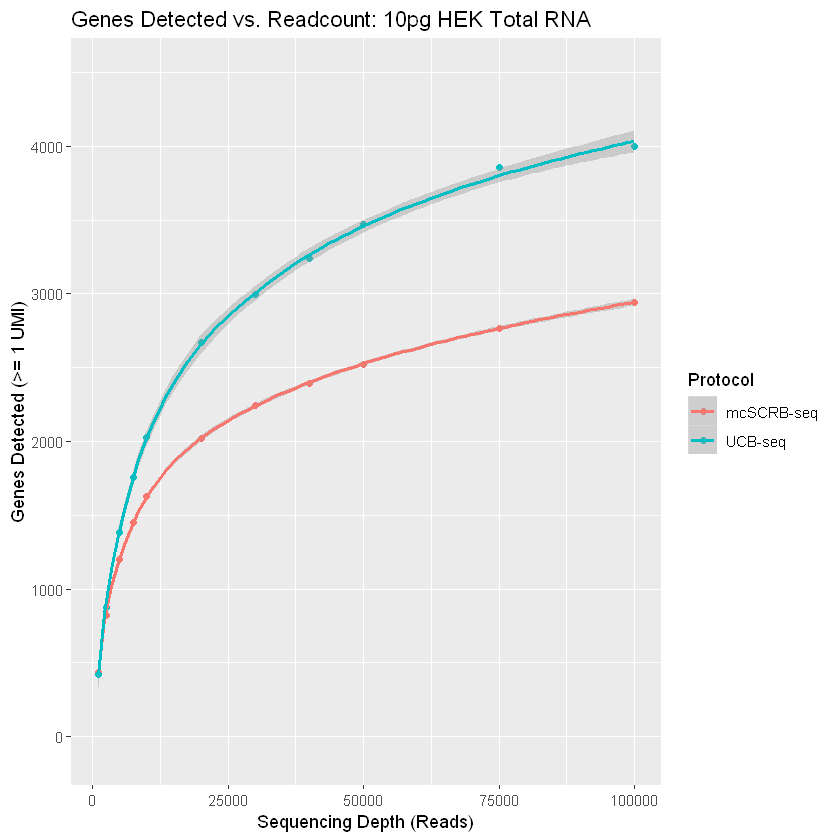

In [48]:
# Plot Genes Detected

ggplot(masterGeneDf, aes(x = Reads, y = Genes, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('Genes Detected (>= 1 UMI)') +
ggtitle('Genes Detected vs. Readcount: 10pg HEK Total RNA') +
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'UCB-seq')) +
ylim(-100, 4500)

## Boxplot of Genes and UMIs by Protocol

In [56]:
temp1 <- cbind(TC012AUMIMat, TC012BUMIMat)['downsampled_50000',]
names(temp1) <- NULL
temp2 <- cbind(TC012AGeneMat, TC012BGeneMat)['downsampled_50000',]
names(temp2) <- NULL
temp1 <- temp1[!is.na(temp1)]
temp2 <- temp2[!is.na(temp2)]

ucbBoxData <- as.data.frame(cbind(temp1, temp2))
ucbBoxData$Protocol <- c(rep('uCB-seq'))
colnames(ucbBoxData) <- c('UMIs', 'Genes', 'Protocol')

temp1 <- cbind(TC010AUMIMat, TC010BUMIMat)['downsampled_50000',]
names(temp1) <- NULL
temp2 <- cbind(TC010AGeneMat, TC010BGeneMat)['downsampled_50000',]
names(temp2) <- NULL
temp1 <- temp1[!is.na(temp1)]
temp2 <- temp2[!is.na(temp2)]

mcBoxData <- as.data.frame(cbind(temp1, temp2))
mcBoxData$Protocol <- c(rep('mcSCRB-seq'))
colnames(mcBoxData) <- c('UMIs', 'Genes', 'Protocol')

boxData <- rbind(ucbBoxData, mcBoxData)

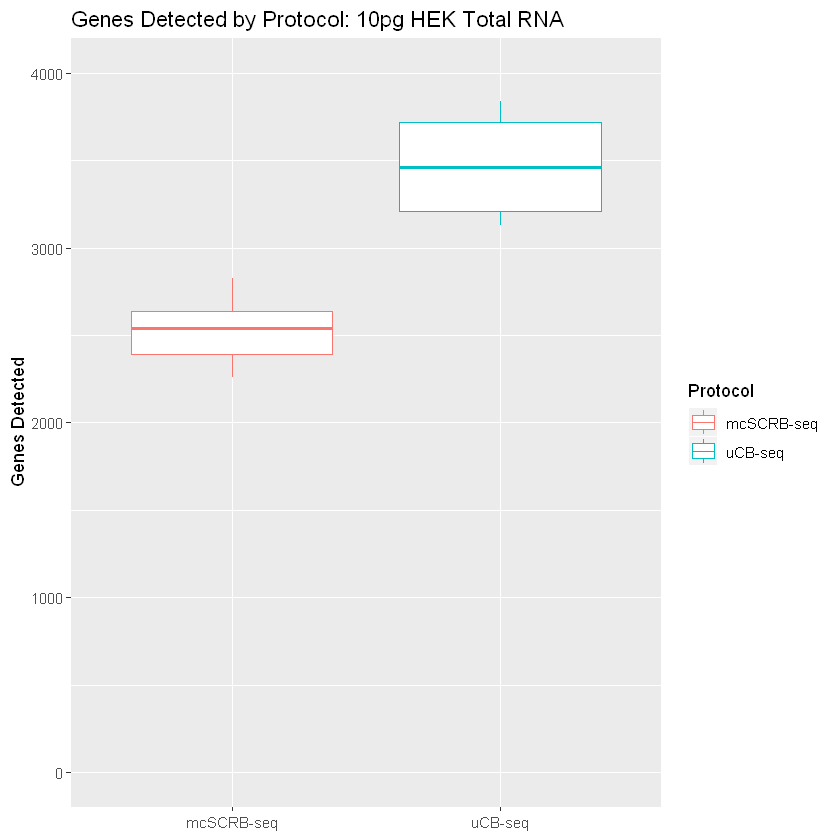

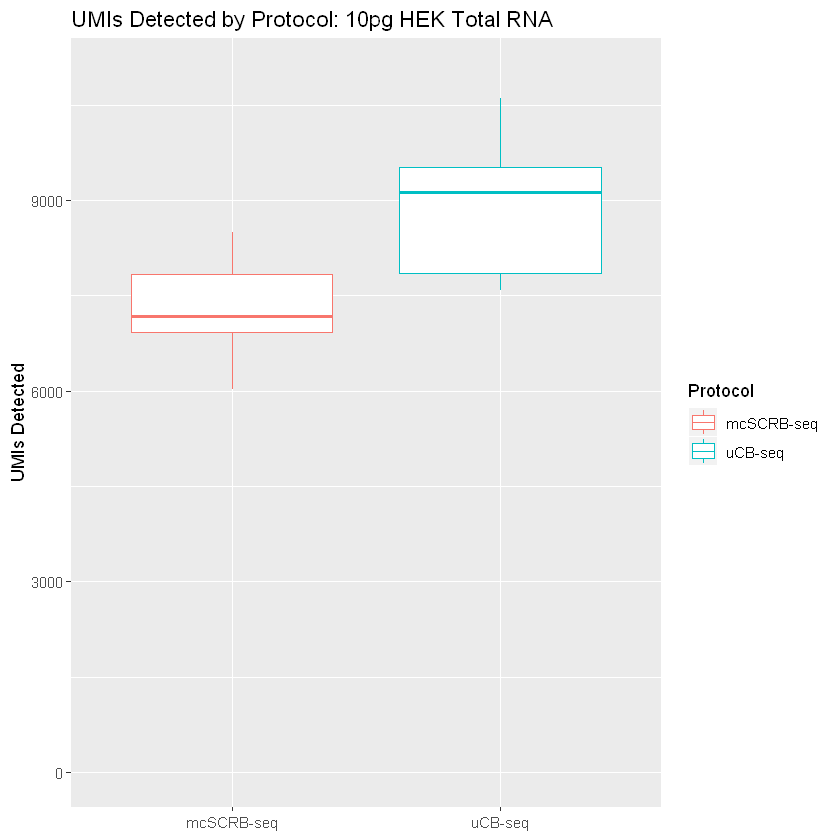

In [59]:
# Genes Detected
ggplot(boxData, aes(x=Protocol, y=Genes, color=Protocol)) + 
geom_boxplot() + 
xlab(NULL) +
ylab('Genes Detected') +
ggtitle('Genes Detected by Protocol: 10pg HEK Total RNA') +
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) +
ylim(0, 4000)

# UMIs Detected
ggplot(boxData, aes(x=Protocol, y=UMIs, color=Protocol)) + 
geom_boxplot() + 
xlab(NULL) +
ylab('UMIs Detected') +
ggtitle('UMIs Detected by Protocol: 10pg HEK Total RNA') +
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'uCB-seq')) +
ylim(0, 11000)

# Single Cell Downsampling Analysis

In [ ]:
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC014Final/')
TC014A <- readRDS('TC014A.dgecounts.rds')
TC014B <- readRDS('TC014B.dgecounts.rds')
setwd('C:/Users/tyler/Desktop/Downsampled zUMIs/out/TC011Final/')
TC011C <- readRDS('TC011C.dgecounts.rds')
TC011D <- readRDS('TC011D.dgecounts.rds')

In [ ]:
paste('TC011C', barcodes)
paste0(', sample, ',barcodes)')

In [ ]:
samples <- c('TC011C', 'TC011D', 'TC014A', 'TC014B')
barcodes <- c('TCACAGCA', 'GTAGCACT', 'ATAGCGTC', 'CTAGCTGA','CTACGACA', 'GTACGCAT', 'ACATGCGT', 'GCATGTAC', 'ATACGTGC', 'GCAGTATC')

# Initialize Gene and UMI matrices for all samples at 18 different downsampling values
TC014AGeneMat <- matrix(, nrow = 18, ncol = 10)
TC014AUMIMat <- matrix(, nrow = 18, ncol = 10)
TC014BGeneMat <- matrix(, nrow = 18, ncol = 10)
TC014BUMIMat <- matrix(, nrow = 18, ncol = 10)
TC011CGeneMat <- matrix(, nrow = 18, ncol = 10)
TC011CUMIMat <- matrix(, nrow = 18, ncol = 10)
TC011DGeneMat <- matrix(, nrow = 18, ncol = 10)
TC011DUMIMat <- matrix(, nrow = 18, ncol = 10)

# Define downsampling range to look at as 1M-1k from TC014A
allDepths <- names(TC014A$umicount$exon$downsampling)

for (sample in samples) {
    # Name columns and rows of all matrices for easy indexing
    eval(parse(text = paste0('colnames(', sample, 'GeneMat) <- ', sample, 'barcodes)')))
    eval(parse(text = paste0('rownames(', sample, 'GeneMat) <- allDepths')))
    eval(parse(text = paste0('colnames(', sample, 'UMIMat) <- ', sample, 'barcodes)')))
    eval(parse(text = paste0('rownames(', sample, 'UMIMat) <- allDepths')))

    eval(parse(text = paste0(sample, 'Depths <- names(', sample, '$umicount$', lookAt, '$downsampling)')))
    for (depth in allDepths) {
        # Check if this specific sample has barcodes with enough reads for specified seq depth
        if (depth %in% eval(parse(text = paste0(sample, 'Depths')))) {
            eval(parse(text = paste0('allowedBarcodes <- colnames(', sample, '$umicount$', lookAt, '$downsampling$', depth, ')')))
            for (barcode in allowedBarcodes) {
                # If barcode is a non-cell barcode, set value to NA
                if (barcode %in% eval(parse(text = paste0(sample, 'NegList')))) {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- NA')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- NA')))
                } else {
                    eval(parse(text = paste0(sample, 'GeneMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"] >= 1)')))
                    eval(parse(text = paste0(sample, 'UMIMat["', depth, '","', barcode, '"] <- sum(', sample, '$umicount$', lookAt, '$downsampling$', depth, '[,"', barcode, '"])')))
                }
            }
        }
    }
    
}

cbind(TC011CGeneMat, TC011DGeneMat, TC014AGeneMat, TC014BGeneMat)

In [123]:
masterGeneMat <- matrix(, nrow = 18, ncol = 3)
masterUMIMat <- matrix(, nrow = 18, ncol = 3)

# Set column/row names for indexing
colnames(masterGeneMat) <- c('Reads', 'mcSCRB-seq', 'UCB-seq')
rownames(masterGeneMat) <- allDepths
colnames(masterUMIMat) <- c('Reads', 'mcSCRB-seq', 'UCB-seq')
rownames(masterUMIMat) <- allDepths

for (depth in allDepths) {
    # Get substring from end of downsampled_DEPTH as numeric for read count
    masterGeneMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    masterUMIMat[depth,'Reads'] <- as.numeric(unlist(strsplit(depth,'_'))[2])
    
    # Get average Gene Count for mcSCRB-seq and UCB-seq by summing the counts from each experiment and dividing by 
    # the number of barcodes included in each experiment at that read depth.
    masterGeneMat[depth,'mcSCRB-seq'] <- ((sum(TC011CGeneMat[depth,], na.rm = TRUE) + sum(TC011DGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC011CGeneMat[depth,])) + sum(!is.na(TC011DGeneMat[depth,]))))
    masterUMIMat[depth,'mcSCRB-seq'] <- ((sum(TC011CUMIMat[depth,], na.rm = TRUE) + sum(TC011DUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC011CUMIMat[depth,])) + sum(!is.na(TC011DUMIMat[depth,]))))
    masterGeneMat[depth,'UCB-seq'] <- ((sum(TC014AGeneMat[depth,], na.rm = TRUE) + sum(TC014BGeneMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC014AGeneMat[depth,])) + sum(!is.na(TC014BGeneMat[depth,]))))
    masterUMIMat[depth,'UCB-seq'] <- ((sum(TC014AUMIMat[depth,], na.rm = TRUE) + sum(TC014BUMIMat[depth,], na.rm = TRUE))
                                                / (sum(!is.na(TC014AUMIMat[depth,])) + sum(!is.na(TC014BUMIMat[depth,]))))
}
masterGeneDf <- as.data.frame(masterGeneMat)
masterGeneDf <- melt(masterGeneDf, id=c("Reads"))
colnames(masterGeneDf)[colnames(masterGeneDf) == 'variable'] <- 'Protocol'
colnames(masterGeneDf)[colnames(masterGeneDf) == 'value'] <- 'Genes'

masterUMIDf <- as.data.frame(masterUMIMat)
masterUMIDf <- melt(masterUMIDf, id=c("Reads"))
colnames(masterUMIDf)[colnames(masterUMIDf) == 'variable'] <- 'Protocol'
colnames(masterUMIDf)[colnames(masterUMIDf) == 'value'] <- 'UMIs'

Warning message in melt(masterGeneDf, id = c("Reads")):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(masterGeneDf). In the next version, this warning will become an error."Warning message in melt(masterUMIDf, id = c("Reads")):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(masterUMIDf). In the next version, this warning will become an error."

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'
Warning message:
"Removed 6 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

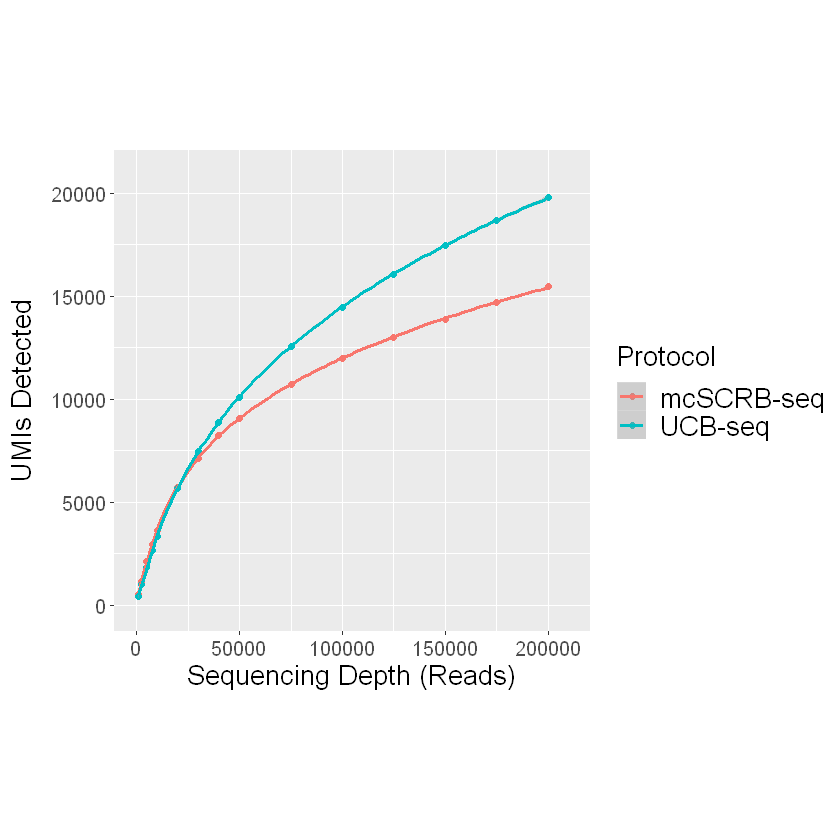

In [125]:
# Plot UMIs Detected

ggplot(masterUMIDf, aes(x = Reads, y = UMIs, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('UMIs Detected') +
# ggtitle('UMIs Detected vs. Readcount: Single-Cell HEK') + 
scale_color_discrete(name = 'Protocol', labels = c('mcSCRB-seq', 'UCB-seq')) + 
ylim(-200, 21000) + 
xlim(0, 210000) +
coord_fixed(ratio=10) +
theme(plot.title = element_text(size=24), axis.text.x = element_text(size=12), axis.title.x = element_text(size=16), axis.title.y = element_text(size=16, margin = margin(t = 0, r = 10, b = 0, l = 0)),
      axis.text.y = element_text(size=12), legend.text = element_text(size=16), legend.title = element_text(size=16))

`geom_smooth()` using method = 'loess' and formula 'y ~ log(x)'
Warning message:
"Removed 6 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

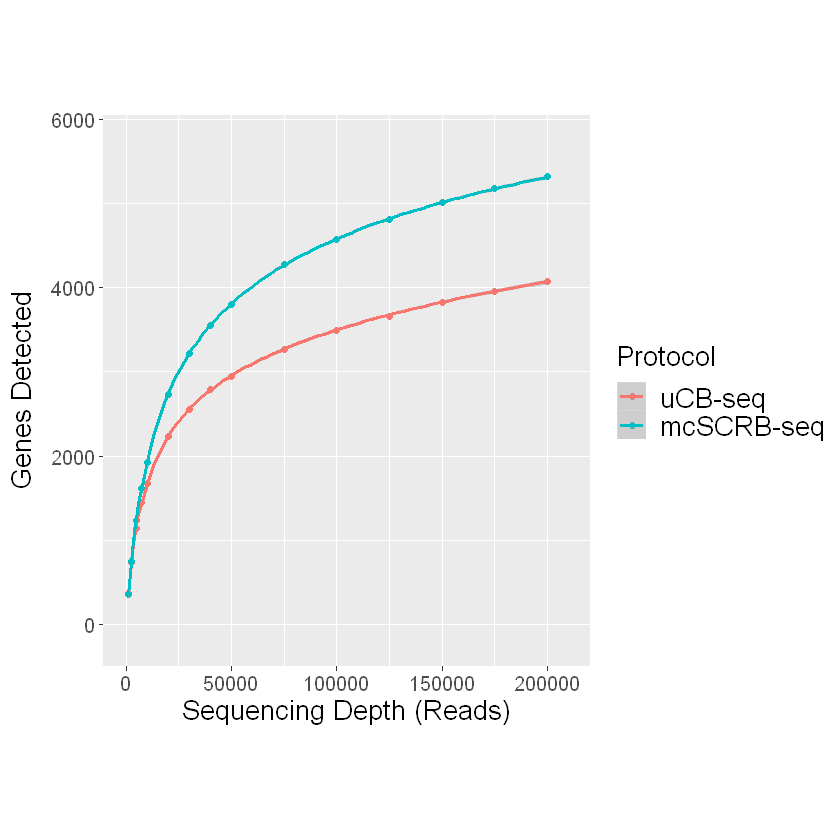

In [126]:
# Plot Genes Detected

ggplot(masterGeneDf, aes(x = Reads, y = Genes, color = Protocol)) + 
geom_point() +
geom_smooth(formula = y ~ log(x)) +
xlab('Sequencing Depth (Reads)') +
ylab('Genes Detected') +
# ggtitle('Library Complexity') +
scale_color_discrete(name = 'Protocol', labels = c('uCB-seq', 'mcSCRB-seq')) +
ylim(-200, 5750) + 
xlim(0, 210000) + 
coord_fixed(ratio=40)+
theme(plot.title = element_text(size=24), axis.text.x = element_text(size=12), axis.title.x = element_text(size=16), axis.title.y = element_text(size=16, margin = margin(t = 0, r = 10, b = 0, l = 0)),
      axis.text.y = element_text(size=12), legend.text = element_text(size=16), legend.title = element_text(size=16))